## Imports


In [527]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#MLFLOW
import mlflow
mlflow.autolog()

2023/12/12 18:00:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/12/12 18:00:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/12/12 18:00:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/12/12 18:00:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


## Données  


In [528]:
# List files available
print(os.listdir("raw_data"))

['application_train.csv']


In [529]:
# Training data
app_train = pd.read_csv('raw_data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

307511 observations et 122 features (variables) incluants la `TARGET` (étiquette à predire).

In [530]:
app_train = app_train.sample(frac =.20)
app_train.shape

(61502, 122)

In [531]:
labels = app_train['TARGET']

In [532]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(app_train, labels, shuffle=True, train_size=0.8, random_state=42)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (49201, 122) et y_train de forme (49201,)
Nous avons X_temp de forme (12301, 122) et y_temp de forme (12301,)


In [533]:
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.5, random_state=42) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
X_valid = X_valid.drop(X_valid.index[[0]])
y_valid = y_valid.drop(X_valid.index[[0]])
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (6150, 122) et y_test de forme (6150,)
Nous avons X_valid de forme (6150, 122) et y_valid de forme (6150,)


# Analyse exploratoire de données

## Distribution de la cible
0 pour un pret remboursé à temps et 1 pour un client avec difficultés de paiments.

In [534]:
y_train.value_counts()

TARGET
0    45145
1     4056
Name: count, dtype: int64

In [535]:
from numpy import bincount

49201 / 3922

12.544875063742989

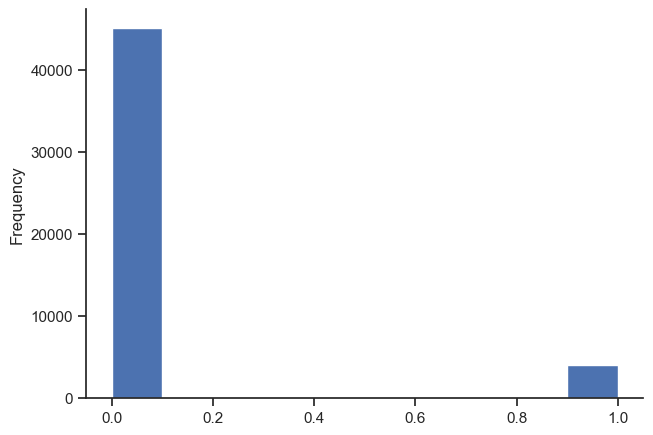

In [536]:
y_train.astype(int).plot.hist();

## NaN

<Axes: >

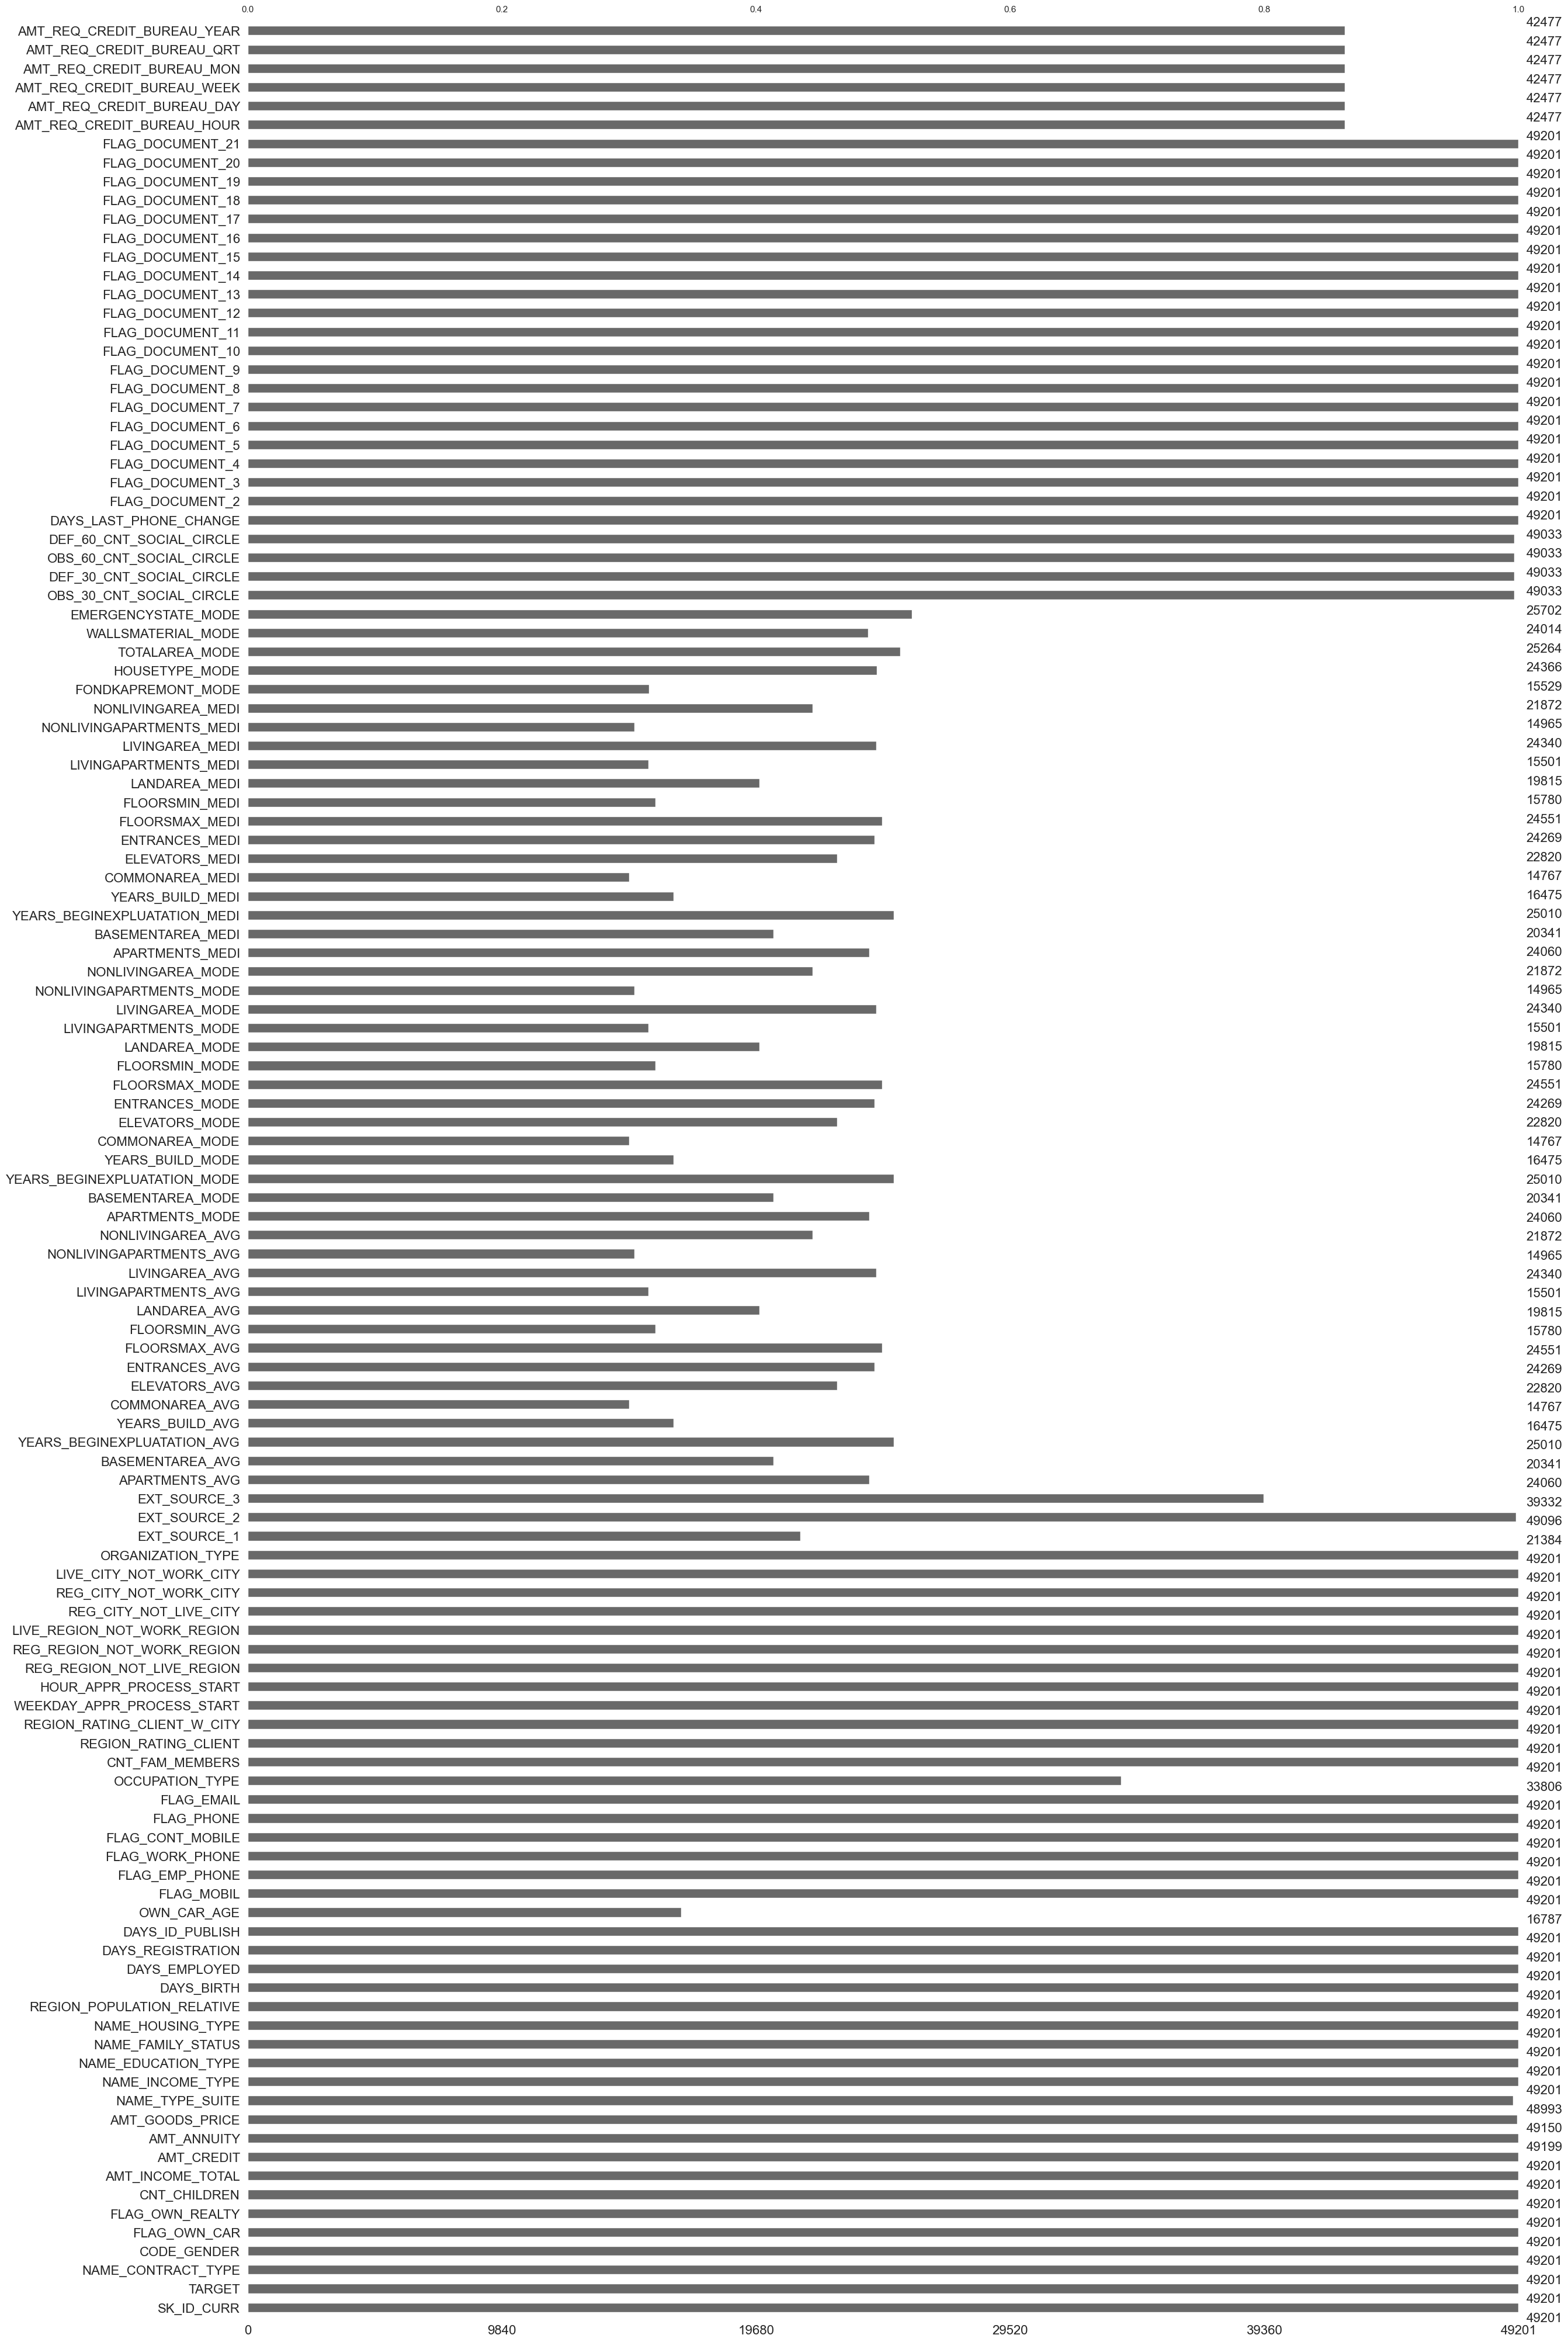

In [537]:
import missingno as msn
msn.bar(X_train)

## Types des colonnes

In [538]:
# Number of each type of column
X_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [539]:
# Number of unique classes in each object column
X_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [540]:
print(X_train['DAYS_EMPLOYED'].describe(),
X_test['DAYS_EMPLOYED'].describe(),
X_valid['DAYS_EMPLOYED'].describe())

count     49201.000000
mean      63344.243267
std      140896.898316
min      -17139.000000
25%       -2769.000000
50%       -1213.000000
75%        -284.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      60729.640000
std      138673.861052
min      -16495.000000
25%       -2775.500000
50%       -1266.000000
75%        -329.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      63280.265203
std      140880.148542
min      -15488.000000
25%       -2856.500000
50%       -1207.000000
75%        -298.250000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


In [541]:
X_train['DAYS_EMPLOYED'] = abs(X_train['DAYS_EMPLOYED'])
X_test['DAYS_EMPLOYED'] = abs(X_test['DAYS_EMPLOYED'])
X_valid['DAYS_EMPLOYED'] = abs(X_valid['DAYS_EMPLOYED'])

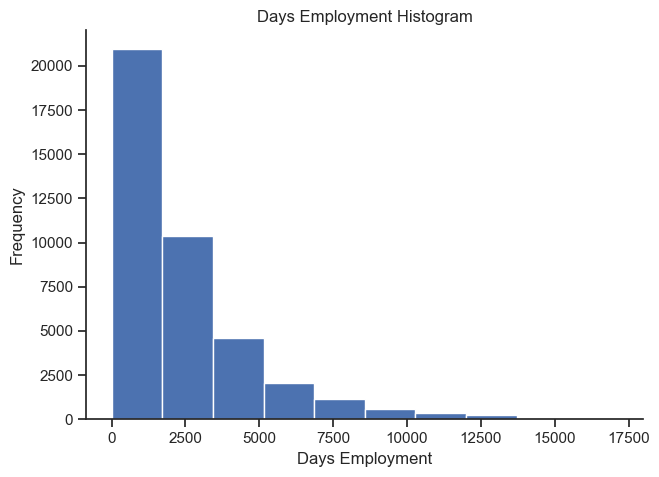

In [542]:
# Create an anomalous flag column
X_train['DAYS_EMPLOYED_ANOM'] = X_train["DAYS_EMPLOYED"] == 365243
X_test['DAYS_EMPLOYED_ANOM'] = X_test["DAYS_EMPLOYED"] == 365243
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
X_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
X_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
X_valid["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

X_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [543]:
(X_train['DAYS_BIRTH'] / -365).describe()
(X_test['DAYS_BIRTH'] / -365).describe()
(X_valid['DAYS_BIRTH'] / -365).describe()

count    6150.000000
mean       44.017815
std        11.973870
min        21.098630
25%        33.948630
50%        43.256164
75%        53.960959
max        69.030137
Name: DAYS_BIRTH, dtype: float64

In [544]:
# Find the correlation of the positive days since birth and target
X_train['DAYS_BIRTH'] = abs(X_train['DAYS_BIRTH'])
X_test['DAYS_BIRTH'] = abs(X_test['DAYS_BIRTH'])
X_valid['DAYS_BIRTH'] = abs(X_valid['DAYS_BIRTH'])
X_train['DAYS_BIRTH'].corr(X_train['TARGET'])

-0.07275569921408476

### Effet de l'age sur le remboursement

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 
Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

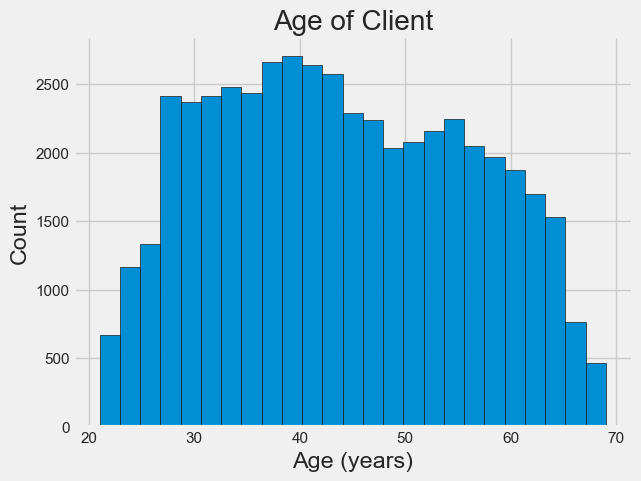

In [545]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(X_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

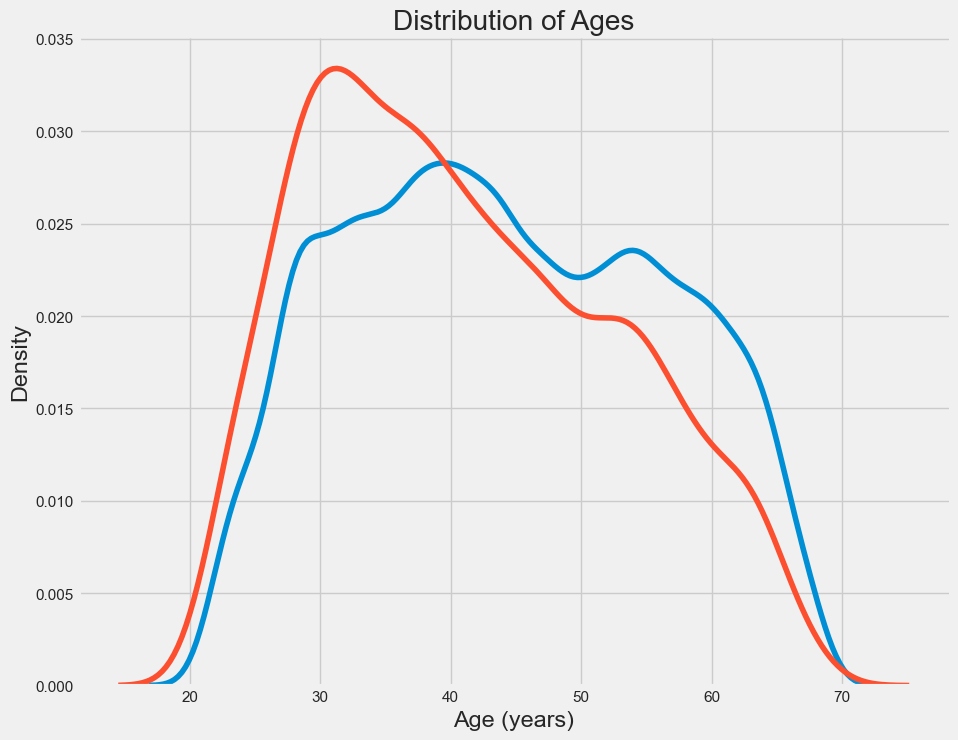

In [546]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par "découper" la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [547]:
# Age information into a separate dataframe
age_data = X_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
267794       0        8568    23.473973  (20.0, 25.0]
167246       0       19459    53.312329  (50.0, 55.0]
122065       0       16704    45.764384  (45.0, 50.0]
299160       0       16729    45.832877  (45.0, 50.0]
233457       0       16326    44.728767  (40.0, 45.0]
100418       0       22550    61.780822  (60.0, 65.0]
24601        0       19584    53.654795  (50.0, 55.0]
281655       0       21935    60.095890  (60.0, 65.0]
54295        0       17223    47.186301  (45.0, 50.0]
161700       0       19912    54.553425  (50.0, 55.0]

In [548]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.122642   8516.708071    23.333447
(25.0, 30.0]  0.108977  10154.447318    27.820404
(30.0, 35.0]  0.105505  11869.095034    32.518069
(35.0, 40.0]  0.091029  13702.551891    37.541238
(40.0, 45.0]  0.076337  15493.377502    42.447610
(45.0, 50.0]  0.078281  17319.246969    47.449992
(50.0, 55.0]  0.073727  19190.965347    52.577987
(55.0, 60.0]  0.059824  20978.095757    57.474235
(60.0, 65.0]  0.052692  22778.779840    62.407616
(65.0, 70.0]  0.039114  24285.209594    66.534821

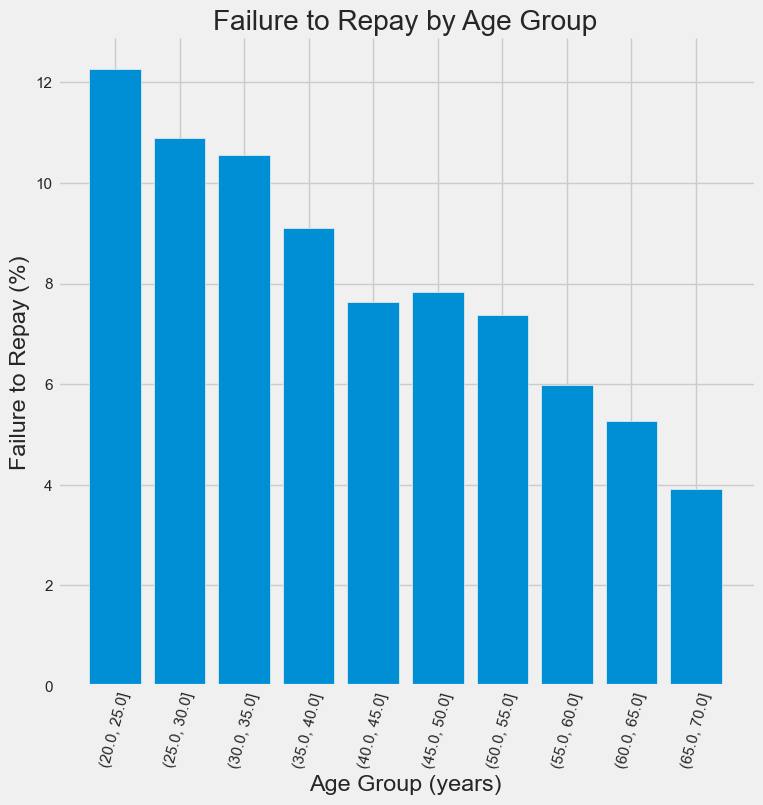

In [549]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Variables Exterior Sources

Les 3 variables avec forte corrélation negative avec la cible = `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Il s'agit d'une d'évaluation cumulative du crédit réalisée à partir de données externes. 
Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [550]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = X_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.161768     -0.164972     -0.182807   -0.072756
EXT_SOURCE_1 -0.161768      1.000000      0.212454      0.203339    0.607181
EXT_SOURCE_2 -0.164972      0.212454      1.000000      0.116618    0.086714
EXT_SOURCE_3 -0.182807      0.203339      0.116618      1.000000    0.211588
DAYS_BIRTH   -0.072756      0.607181      0.086714      0.211588    1.000000

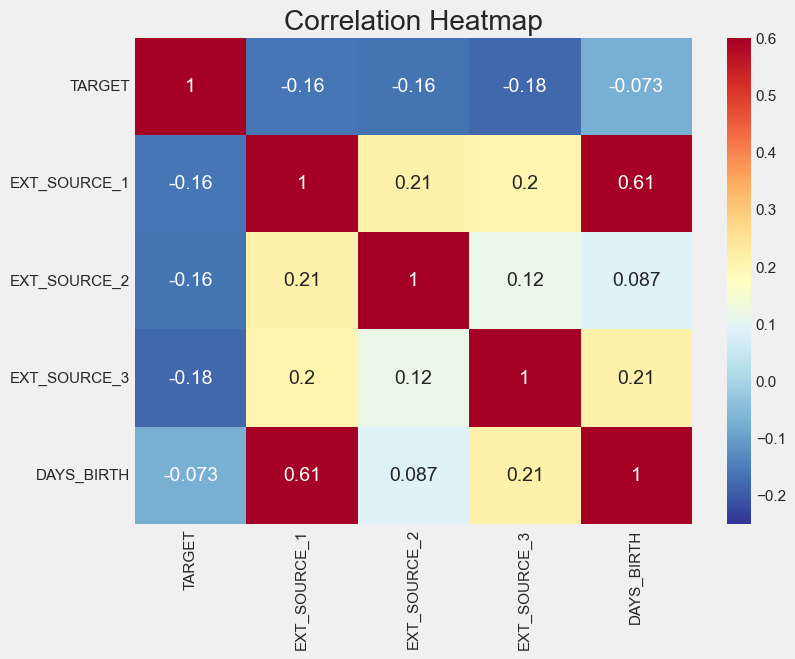

In [551]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de `EXT_SOURCE` augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons regarder la distribution de chacune de ces caractéristiques colorée par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

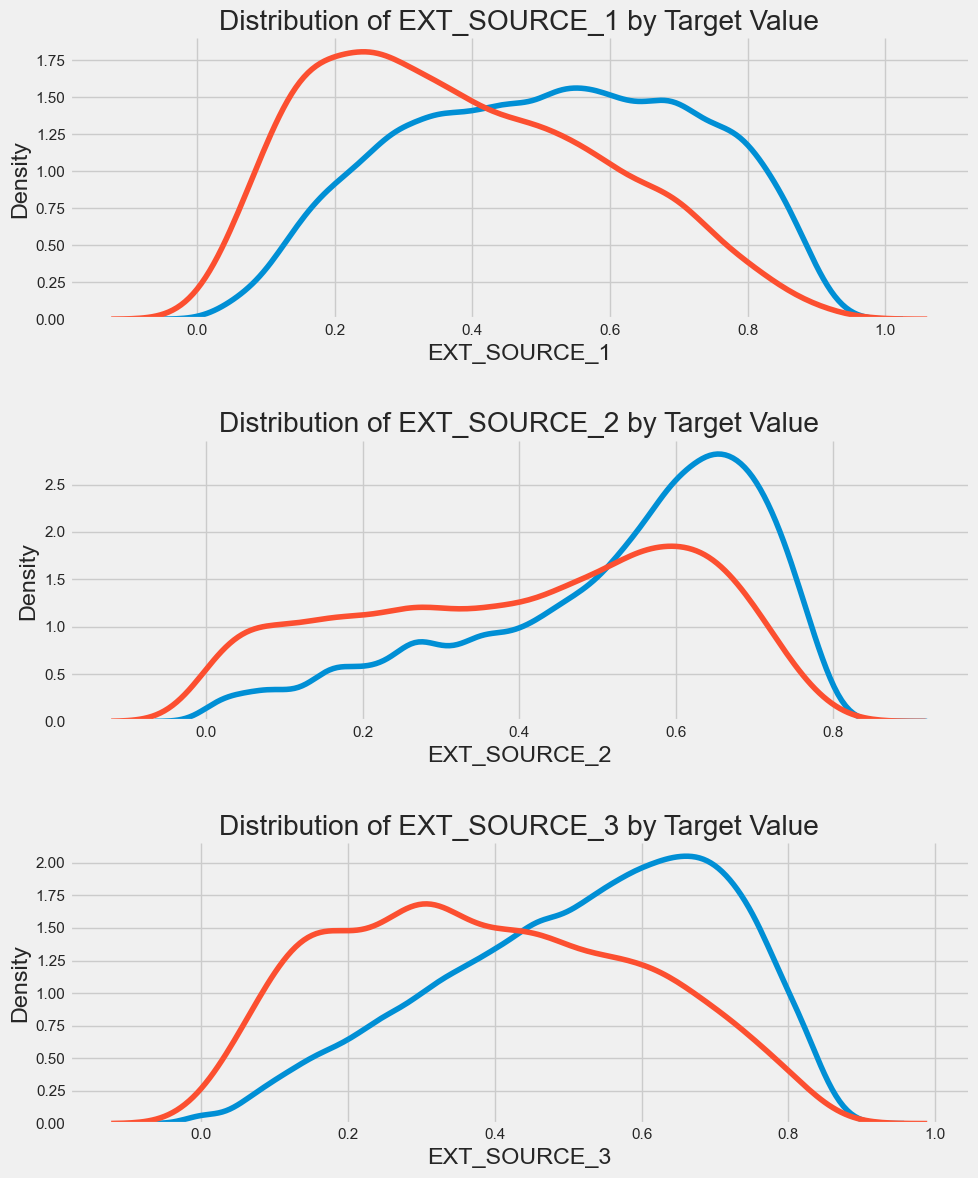

In [552]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt.

# Feature Engineering


## Features connaissance domaine

Ici, je vais utiliser cinq caractéristiques qui ont été inspirées par [ce script] (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport au revenu du client.
* `ANNUITY_INCOME_PERCENT` : le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM` : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
* `DAYS_EMPLOYED_PERCENT` : le pourcentage des jours de travail par rapport à l'âge du client.


In [553]:
X_train['CREDIT_INCOME_PERCENT'] = X_train['AMT_CREDIT'] / X_train['AMT_INCOME_TOTAL']
X_train['ANNUITY_INCOME_PERCENT'] = X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL']
X_train['CREDIT_TERM'] = X_train['AMT_ANNUITY'] / X_train['AMT_CREDIT']
X_train['DAYS_EMPLOYED_PERCENT'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']

In [554]:
X_test['CREDIT_INCOME_PERCENT'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['ANNUITY_INCOME_PERCENT'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['CREDIT_TERM'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['DAYS_EMPLOYED_PERCENT'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

In [555]:
X_valid['CREDIT_INCOME_PERCENT'] = X_valid['AMT_CREDIT'] / X_valid['AMT_INCOME_TOTAL']
X_valid['ANNUITY_INCOME_PERCENT'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_INCOME_TOTAL']
X_valid['CREDIT_TERM'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_CREDIT']
X_valid['DAYS_EMPLOYED_PERCENT'] = X_valid['DAYS_EMPLOYED'] / X_valid['DAYS_BIRTH']

In [556]:
X_test.describe()

SK_ID_CURR       TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count    6150.000000  6150.000000   6150.000000      6.150000e+03   
mean   279728.571057     0.083902      0.432683      1.676421e+05   
std    102526.552697     0.277264      0.761066      8.911894e+04   
min    100011.000000     0.000000      0.000000      2.700000e+04   
25%    190992.750000     0.000000      0.000000      1.125000e+05   
50%    281075.000000     0.000000      0.000000      1.485000e+05   
75%    367240.750000     0.000000      1.000000      2.025000e+05   
max    456232.000000     1.000000     14.000000      1.125000e+06   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  6.150000e+03    6150.000000     6.146000e+03   
mean   6.042356e+05   27166.554878     5.424553e+05   
std    4.008726e+05   14332.356839     3.664730e+05   
min    4.500000e+04    2893.500000     4.500000e+04   
25%    2.700000e+05   16645.500000     2.385000e+05   
50%    5.189220e+05   25065.000000     4.500000e+05   
75%    8.140410e+05   34951.500000     6.885000e+05   
max    2.931660e+06  225000.000000     2.700000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count                 6150.000000   6150.000000    5094.000000  ...   
mean                     0.021228  15989.310407    2396.804476  ...   
std                      0.014046   4320.066949    2322.548649  ...   
min                      0.000533   7700.000000       5.000000  ...   
25%                      0.010032  12422.750000     799.000000  ...   
50%                      0.018850  15730.500000    1678.000000  ...   
75%                      0.028663  19523.750000    3191.750000  ...   
max                      0.072508  25187.000000   16495.000000  ...   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                 5308.000000                5308.000000   
mean                     0.006217                   0.006405   
std                      0.095888                   0.098779   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      3.000000                   3.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                 5308.000000                5308.000000   
mean                     0.034099                   0.304823   
std                      0.183566                   1.037528   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                  18.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
count                 5308.00000                 5308.000000   
mean                     0.26413                    1.901469   
std                      0.60953                    1.873092   
min                      0.00000                    0.000000   
25%                      0.00000                    0.000000   
50%                      0.00000                    1.000000   
75%                      0.00000                    3.000000   
max                      5.00000                   13.000000   

       CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
count            6150.000000             6150.000000  6150.000000   
mean                3.999797                0.181436     0.053346   
std                 2.701849                0.095446     0.022445   
min                 0.266500                0.017400     0.023827   
25%                 2.000000                0.112046     0.036127   
50%                 3.274410                0.162099     0.050000   
75%                 5.280326          

In [557]:
X_train.describe()

SK_ID_CURR        TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count   49201.000000  49201.000000  49201.000000      4.920100e+04   
mean   278672.472511      0.082437      0.414727      1.691363e+05   
std    102816.811389      0.275033      0.724239      1.338029e+05   
min    100003.000000      0.000000      0.000000      2.610000e+04   
25%    189638.000000      0.000000      0.000000      1.125000e+05   
50%    279143.000000      0.000000      0.000000      1.485000e+05   
75%    367307.000000      0.000000      1.000000      2.025000e+05   
max    456245.000000      1.000000     19.000000      1.800009e+07   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  4.920100e+04   49199.000000     4.915000e+04   
mean   5.985840e+05   27122.810240     5.384122e+05   
std    4.028295e+05   14513.947305     3.701115e+05   
min    4.500000e+04    1615.500000     4.500000e+04   
25%    2.700000e+05   16542.000000     2.385000e+05   
50%    5.124465e+05   24885.000000     4.500000e+05   
75%    8.086500e+05   34681.500000     6.795000e+05   
max    4.050000e+06  225000.000000     4.050000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count                49201.000000  49201.000000   40403.000000  ...   
mean                     0.020878  16044.552225    2396.054773  ...   
std                      0.013790   4359.847675    2371.499185  ...   
min                      0.000290   7680.000000       6.000000  ...   
25%                      0.010006  12431.000000     762.000000  ...   
50%                      0.018850  15759.000000    1643.000000  ...   
75%                      0.028663  19667.000000    3182.000000  ...   
max                      0.072508  25191.000000   17139.000000  ...   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                42477.000000               42477.000000   
mean                     0.006592                   0.007157   
std                      0.086000                   0.122540   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      3.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                42477.000000               42477.000000   
mean                     0.034113                   0.266403   
std                      0.205030                   0.905032   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      6.000000                  17.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
count               42477.000000                42477.000000   
mean                    0.267839                    1.903760   
std                     1.406148                    1.871109   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    1.000000   
75%                     0.000000                    3.000000   
max                   261.000000                   18.000000   

       CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT   CREDIT_TERM  \
count           49201.000000            49199.000000  49199.000000   
mean                3.950320                0.180909      0.053722   
std                 2.700906                0.095443      0.022414   
min                 0.037500                0.003850      0.022079   
25%                 2.000000                0.114394      0.037060   
50%                 3.248700                0.162611      0.050000   
75%                 5.

In [558]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49201, 127)
(6150, 127)
(6150, 127)


#### Visualisation des nouvelles variables

Nous devrions explorer ces variables de __connaissance domaine__ visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la `TARGET`.

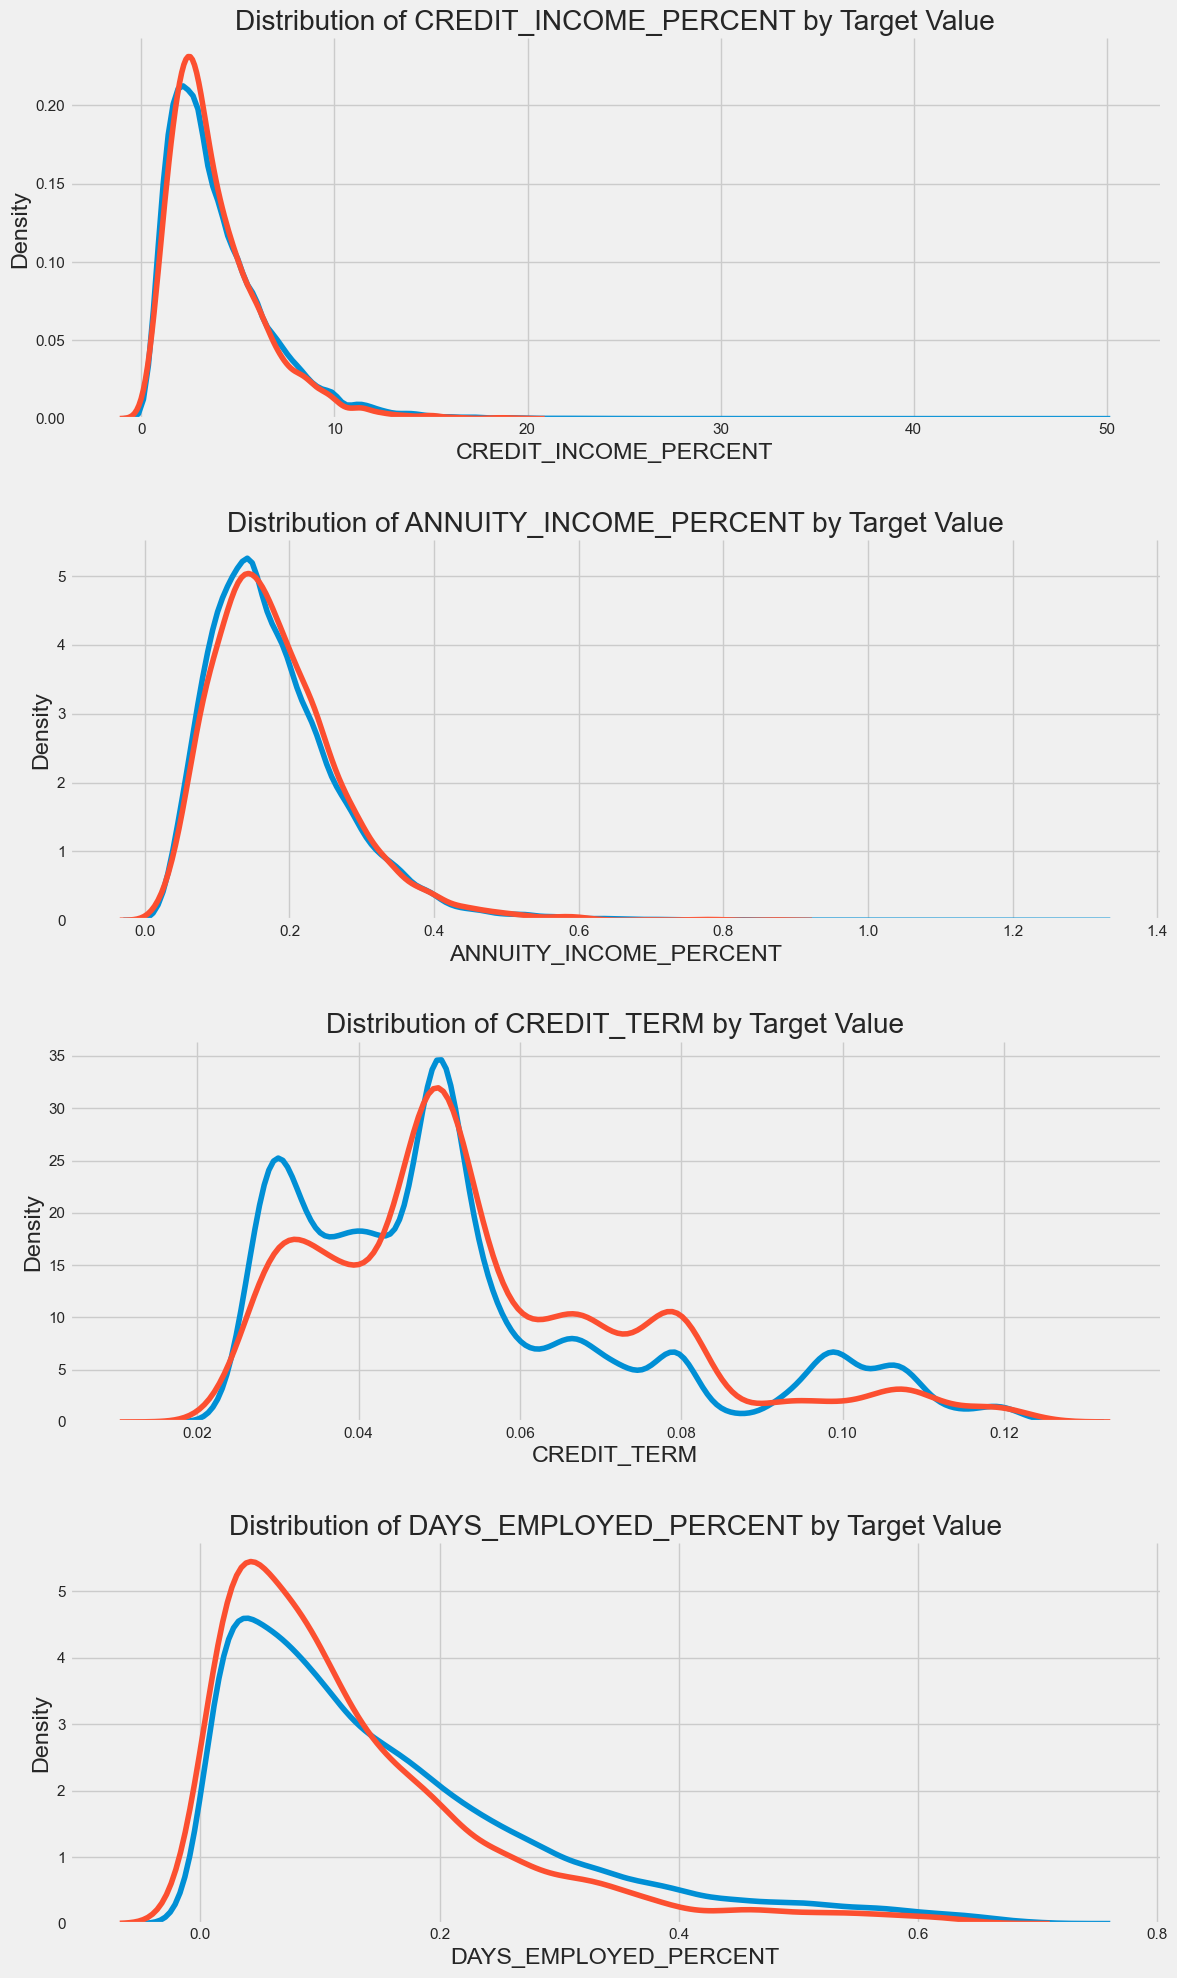

In [559]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [560]:
target_name = "TARGET"
y_train = X_train[target_name]

In [561]:
X_train['DAYS_EMPLOYED_ANOM'] = X_train.select_dtypes(include='bool').astype('uint8')
X_test['DAYS_EMPLOYED_ANOM'] = X_test.select_dtypes(include='bool').astype('uint8')
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid.select_dtypes(include='bool').astype('uint8')
X_train.dtypes.value_counts()

float64    70
int64      40
object     16
uint8       1
Name: count, dtype: int64

In [562]:
X_train.to_csv('X_tr.csv', index=False) 
X_test.to_csv('X_te.csv', index=False) 
#X_valid.to_csv('X_valid.csv',index=False)
y_train.to_csv('y_tr.csv', index=False) 
y_test.to_csv('y_te.csv', index=False)  
#y_valid.to_csv('y_valid.csv',index=False) 

In [563]:
X_train = X_train.drop(columns=['TARGET', 'SK_ID_CURR'])
X_test = X_test.drop(columns=['TARGET', 'SK_ID_CURR'])
X_valid = X_valid.drop(columns=['TARGET', 'SK_ID_CURR'])

In [564]:
test = pd.DataFrame(X_test.iloc[0]).T
#test_json = X_test.iloc[0].to_json()

In [565]:
X_train.to_csv('X_train.csv', index=False) 
X_test.to_csv('X_test.csv', index=False) 
#X_valid.to_csv('X_valid.csv',index=False)
y_train.to_csv('y_train.csv', index=False) 
y_test.to_csv('y_test.csv', index=False)  
#y_valid.to_csv('y_valid.csv',index=False) 

In [566]:
X_train_evidently = X_train.copy()
X_test_evidently = X_test.copy()
X_valid_evidently = X_valid.copy()

y_train_evidently = y_train.copy()
y_test_evidently = y_test.copy()
y_valid_evidently = y_valid.copy()

# Création du pipeline

In [567]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
import xgboost 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn import set_config

features_X_train = X_train.columns
features_X_test = X_test.columns
features_X_valid = X_valid.columns

#class_weight={0:1, 1:12}
# Define the encoding strategy for features
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(exclude="object").columns
n_unique_categories = X_train[categorical_features].nunique().sort_values(ascending=False)
high_cardinality_features = n_unique_categories[n_unique_categories > 15].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 15].index

set_config(transform_output="pandas")

# Define the preprocessing steps for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
high_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('targ', TargetEncoder()),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
low_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('high_cat', high_categorical_transformer, high_cardinality_features),
        ('low_cat', low_categorical_transformer, low_cardinality_features)])


In [568]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# define pipeline
steps1 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', LogisticRegression(random_state=1))]
LogisticRegression = Pipeline(steps=steps1)

steps2 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', DummyClassifier(random_state=1))]
DummyClassifier = Pipeline(steps=steps2)

steps3 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', RandomForestClassifier(random_state=1))]
RandomForest = Pipeline(steps=steps3)

steps4 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model',  GradientBoostingClassifier(random_state=1))]
GradientBoosting = Pipeline(steps=steps4)

steps5 = [('preprocessor', preprocessor), ('over', SMOTE()), ('model', XGBClassifier(random_state=1))]
XGBClass = Pipeline(steps=steps5)

In [569]:
GradientBoosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'AMT_...
                                                  Index(['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'WALLSMATERIAL_MODE', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'FONDKAPREMONT_MODE', 'CODE_GENDER',
       'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('over', SMOTE()),
                ('model', GradientBoostingClassifier(random_state=1))])

# Premier entrainement de modèles

In [570]:
# Création d'une métrique adaptée Fbeta score pour le GridSearchCV https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer

def bank_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=10)

In [571]:
bank_score = make_scorer(bank_metric, greater_is_better=True)

In [572]:
dict_of_models = {"LogisticRegression": LogisticRegression, 
                  "DummyClassifier" : DummyClassifier, 
                  "RandomForest" : RandomForest,
                  "GradientBoosting" : GradientBoosting,
                  "XGBClass" : XGBClass}

In [573]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [574]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import cross_val_score
from time import time
from mlflow import MlflowClient
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from mlflow import log_param, log_metrics, set_tag
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
warnings.filterwarnings("ignore")

def evaluation(model):
        
        with mlflow.start_run() as run:
           
            start_fit = time()
            model.fit(X_train, y_train)
            end_fit = time()
            start_predict_train = time()
            y_pred_train = model.predict(X_train)
            y_proba_train = model.predict_proba(X_train)[:, 1] # keep probabilities for the positive outcome only
            end_predict_train = time()
            start_predict_test = time()
            y_pred_test = model.predict(X_test)
            y_proba_test = model.predict_proba(X_test)[:, 1]
            end_predict_test = time()
        
            bank_metric_train = bank_metric(y_train, y_pred_train)
            bank_metric_test = bank_metric(y_test, y_pred_test)
            roc_auc_score_train = roc_auc_score(y_train, y_proba_train)
            roc_auc_score_test = roc_auc_score(y_test, y_proba_test)
            fit_time = end_fit - start_fit
            predict_time_train = end_predict_train - start_predict_train
            predict_time_test = end_predict_test - start_predict_test
            roc_curve_train = roc_curve(y_train, y_pred_train)
            roc_curve_test = roc_curve(y_test, y_pred_test)
        
            print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
            mlflow.end_run()
        
        df_result = pd.DataFrame({
        "data" : ["train", "test"],
        "bank_metric" : [bank_metric_train, bank_metric_test],
        "AUC" : [roc_auc_score(y_train, y_proba_train), roc_auc_score(y_test, y_proba_test)],
        "fit_time" : [fit_time, fit_time],
        "predict_time" : [predict_time_train, predict_time_test]})
        
        metric = ['bank_metric','AUC', 'fit_time', 'predict_time']
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        fig = plt.figure(figsize=(20,60))

        for i, c in enumerate(metric,1):
            ax = fig.add_subplot(2,4,i)
            sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
            plt.xticks(fontsize= 20)
            plt.yticks(fontsize= 14)
            plt.xlabel("", fontsize= 20)
            plt.ylabel(c, fontsize= 20)
            #plt.ylim(0, 1) 

        plt.tight_layout(w_pad=2, h_pad=1)
        plt.gcf().set_size_inches(16,7)
        plt.show()        
    
        return df_result

LogisticRegression


2023/12/12 18:00:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:00:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:00:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:00:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3d0f5564228740a4a7968c27ce910565. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 3d0f5564228740a4a7968c27ce910565
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'C': '1.0', 'class_weight': 'None', 'dual': 'False', 'fit_intercept': 'True', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'intercept_scaling': '1', 'l1_ratio': 'None', 'leaf_size': '30', 'max_iter': '100', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'multi_class': 'auto', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'penalty': 'l2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'solver': 'lbfgs', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler

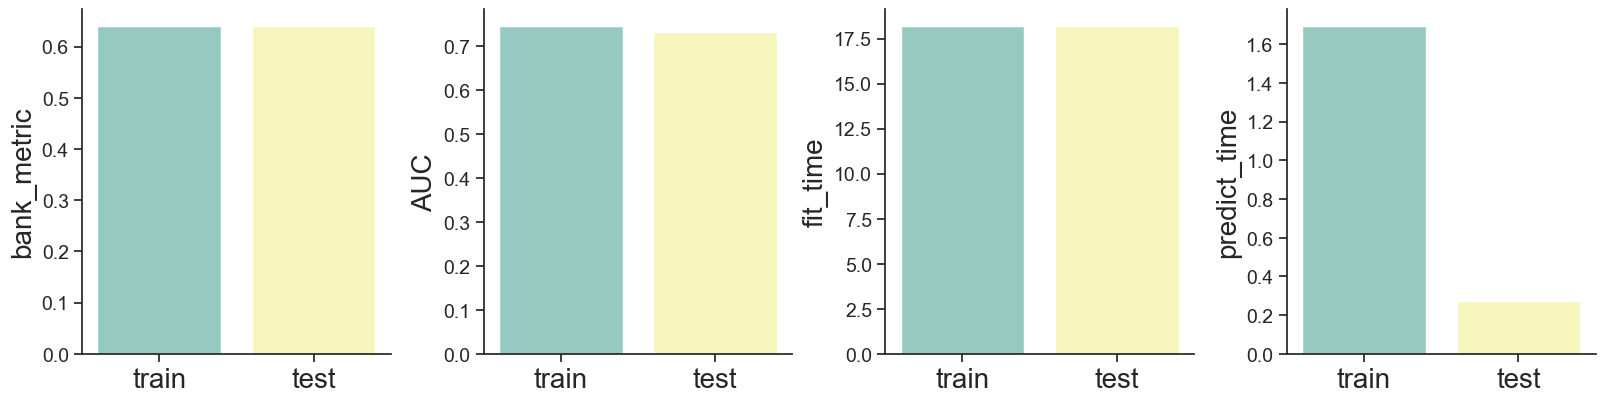

DummyClassifier


2023/12/12 18:01:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:01:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:01:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:01:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5f4028fe577a4233ac0d00848e03017e. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 5f4028fe577a4233ac0d00848e03017e
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'constant': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]", 'strategy': 'prior', 'verbose': 'False'}
metrics: {'fbeta_score-2_Xt-3': 0.0, 'fbeta_score_Xt': 0.0, 'training_accuracy_score': 0.5, 'training_f1_score': 0.3333333333333333, '

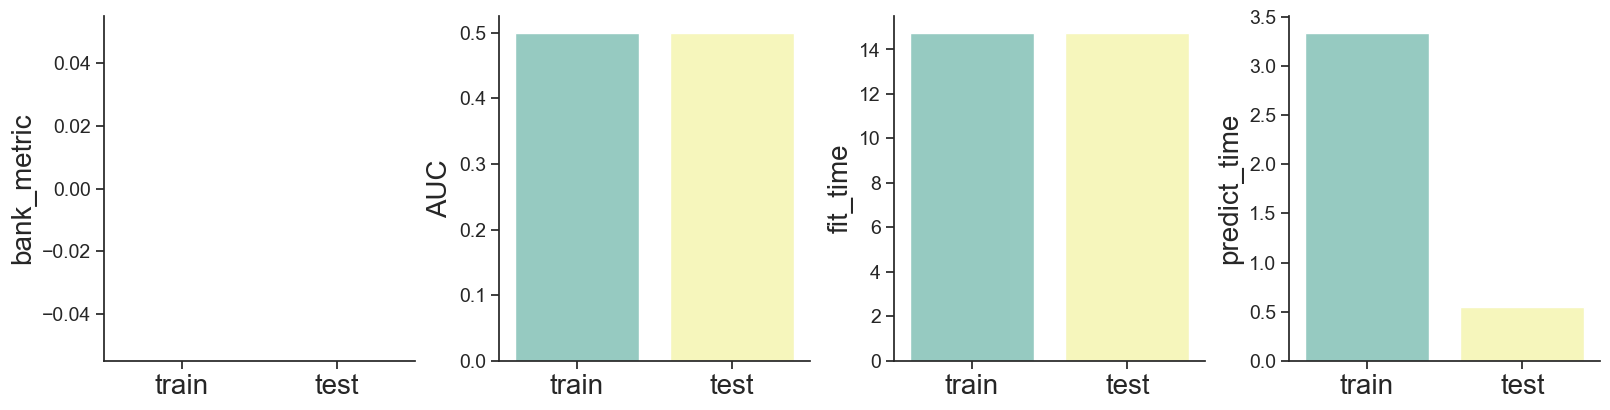

RandomForest


2023/12/12 18:01:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:01:21 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:01:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:01:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 730d8c3dd3ab47db972d329f9f54a22b. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 730d8c3dd3ab47db972d329f9f54a22b
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

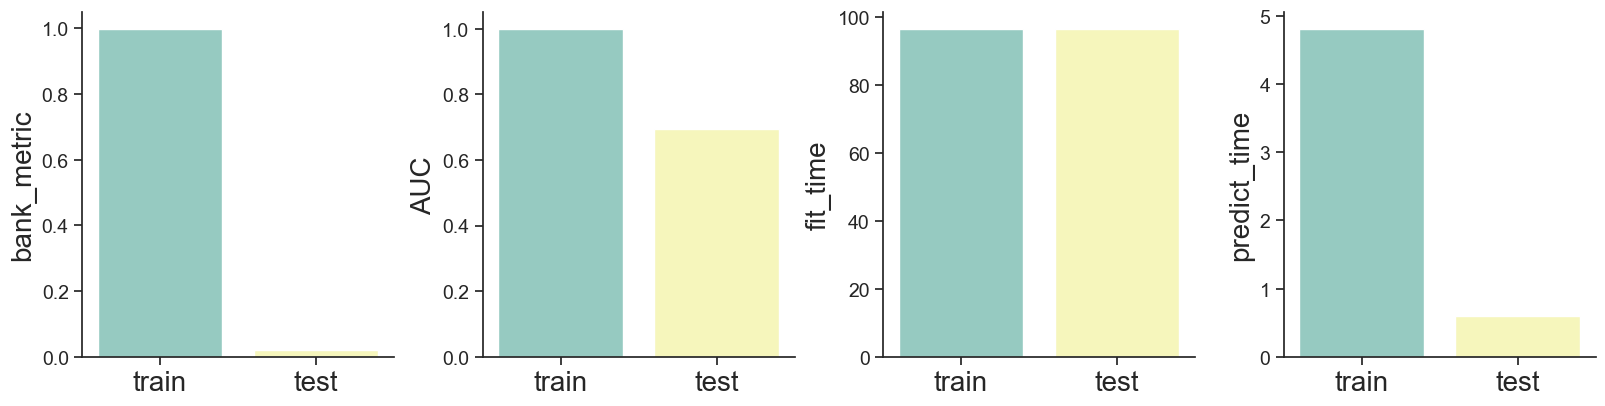

GradientBoosting


2023/12/12 18:03:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:03:03 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:03:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:03:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 08279bcc2ce64a5a8be0ce31a5cba0ab. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 08279bcc2ce64a5a8be0ce31a5cba0ab
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

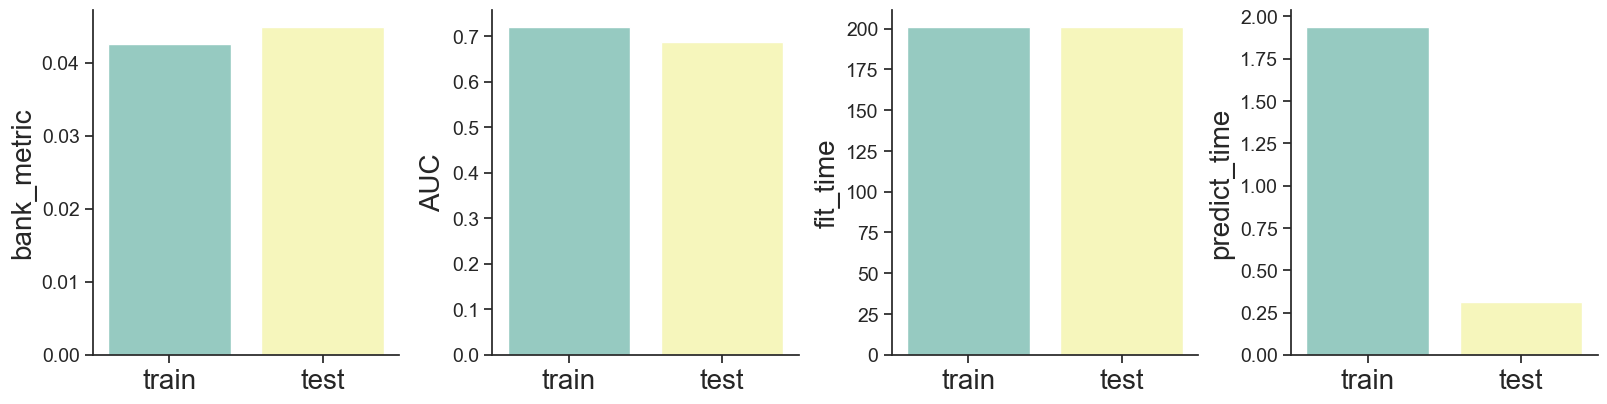

XGBClass


2023/12/12 18:06:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:06:28 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:06:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 18:06:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID fd9f614e7c014a1ba811839225c06dcb. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: fd9f614e7c014a1ba811839225c06dcb
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

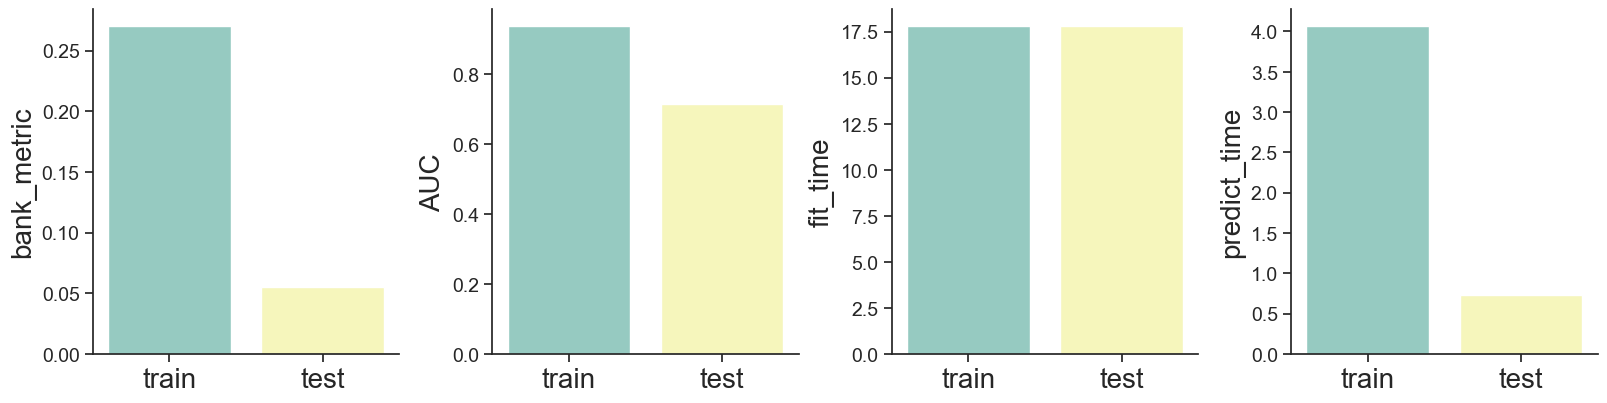

In [575]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

# Cross validation et hparams tuning avec GridsearchCV

Déterminer les meilleurs hparams des modèles. Le scoring GridCV est notre métrique métier. 
Nous évaluons ensuite les probabilités de solvabilité obtenues grâce à des métrics spécifiques (AUC, accuracy_precision_score). 

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter represents the ratio of recall importance to precision importance. beta > 1 gives more weight to recall, while beta < 1 favors precision. For example, beta = 2 makes recall twice as important as precision, while beta = 0.5 does the opposite. Asymptotically, beta -> +inf considers only recall, and beta -> 0 only precision.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

In [576]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the grid
param_grid_rf = {'model__n_estimators': n_estimators,
               'model__max_features': max_features}

In [577]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_gbc = {'model__learning_rate': learning_rate,
                  'model__n_estimators': n_estimators}

In [578]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_xgb = {'model__learning_rate': learning_rate,
                  'model__n_estimators' : n_estimators}


In [579]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_control(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_score)
        grid.fit(X_train, y_train)
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [580]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_bank(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=bank_score)
        grid.fit(X_train, y_train)
    
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [581]:
cv_gridsearch_bank(RandomForest, param_grid_rf)
#{'model__max_features': 'sqrt', 'model__n_estimators': 150}

2023/12/12 18:06:48 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:22:40 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 18:22:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


run_id: 85681045530e490384d0a030300d0e7f
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'best_model__max_features': 'sqrt', 'best_model__n_estimators': '150', 'cv': 'StratifiedKFold(n_splits=5, random_state=None, shuffle=False)', 'error_score': 'nan', 'estimator': "Pipeline(steps=[('preprocessor',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('imputer',\n                                                                   SimpleImputer(strategy='median')),\n                                                                  ('scaler',\n                                                                   MinMaxScaler())]),\n                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',\n       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',\n       'DAYS_EMPLOYE

In [582]:
cv_gridsearch_bank(GradientBoosting, param_grid_gbc)
# {'model__learning_rate': 0.01, 'model__n_estimators': 50}

2023/12/12 18:22:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:42:46 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:42:51 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


run_id: 92ac7fab862c4bb7bd91b020db383260
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'best_model__learning_rate': '0.01', 'best_model__n_estimators': '50', 'cv': 'StratifiedKFold(n_splits=5, random_state=None, shuffle=False)', 'error_score': 'nan', 'estimator': "Pipeline(steps=[('preprocessor',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('imputer',\n                                                                   SimpleImputer(strategy='median')),\n                                                                  ('scaler',\n                                                                   MinMaxScaler())]),\n                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',\n       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',\n       'DAYS_EMPLOYE

In [583]:
cv_gridsearch_bank(XGBClass, param_grid_xgb)
# {'model__learning_rate': 0.01, 'model__n_estimators': 50}

2023/12/12 19:42:52 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:44:23 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:44:28 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


run_id: fda281e0adaa4a72b6044fc287514e35
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'best_model__learning_rate': '0.01', 'best_model__n_estimators': '50', 'cv': 'StratifiedKFold(n_splits=5, random_state=None, shuffle=False)', 'error_score': 'nan', 'estimator': "Pipeline(steps=[('preprocessor',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('imputer',\n                                                                   SimpleImputer(strategy='median')),\n                                                                  ('scaler',\n                                                                   MinMaxScaler())]),\n                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',\n       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',\n       'DAYS_EMPLOYE

# Retrainements avec hparams optimaux

In [584]:
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

steps6 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model', RandomForestClassifier(max_features="sqrt", n_estimators=150, random_state=1))]
RandomForest_tuned = Pipeline(steps=steps6)

steps7 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model',  GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 50, random_state=1))]
GradientBoosting_tuned = Pipeline(steps=steps7)

steps8 = [('preprocessor', preprocessor), ('over', SMOTE()), 
          ('model', XGBClassifier(learning_rate= 0.1, n_estimators= 50, random_state=1))]
XGBClass_tuned = Pipeline(steps=steps8)

In [585]:
dict_of_tuned_models = {"RandomForest" : RandomForest,
                  "GradientBoosting" : GradientBoosting,
                  "XGBClass" : XGBClass,
                  "RandomForest_tuned" : RandomForest_tuned,
                  "GradientBoosting_tuned" : GradientBoosting_tuned,
                  "XGBClass_tuned" : XGBClass_tuned}

RandomForest


2023/12/12 19:44:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:44:32 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:44:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:44:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID f92bef4c896b42d6bc60a47d888af481. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: f92bef4c896b42d6bc60a47d888af481
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

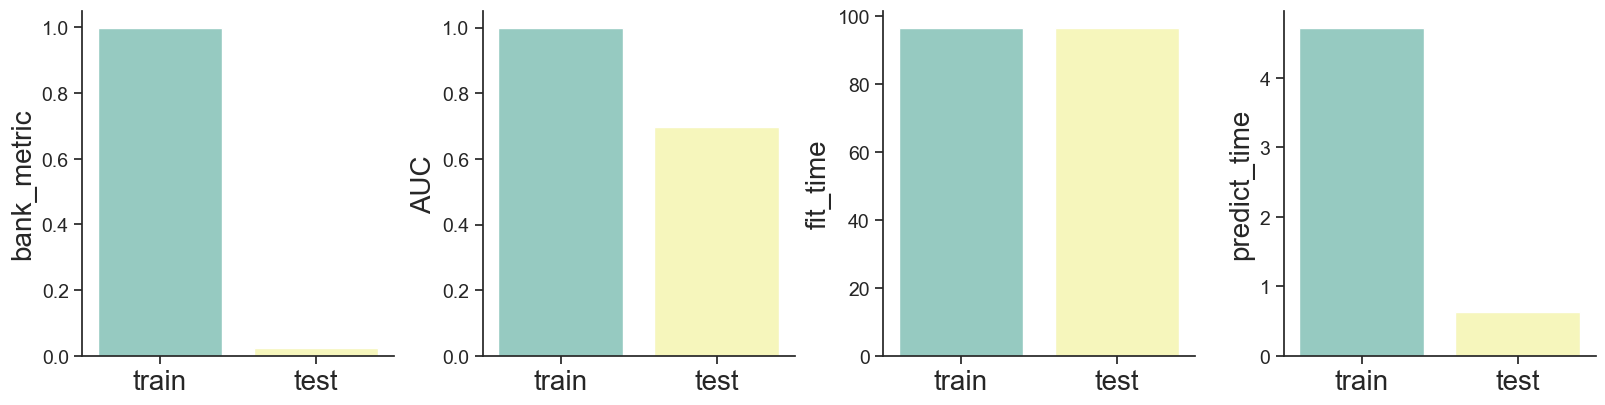

GradientBoosting


2023/12/12 19:46:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:46:14 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:46:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:46:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 0a10affd384444e987bda477b110cf46. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 0a10affd384444e987bda477b110cf46
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

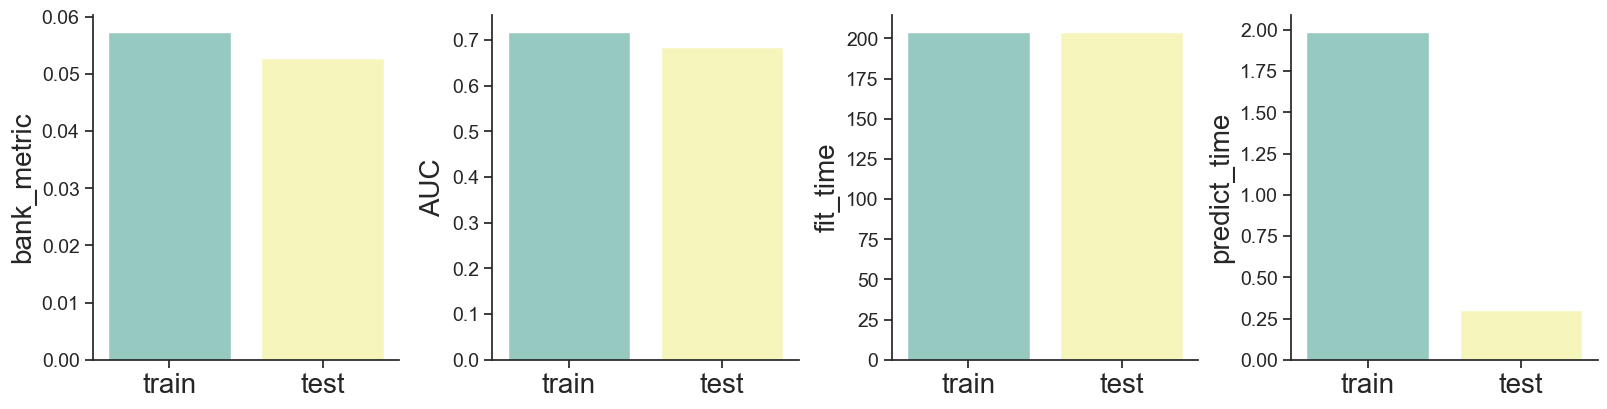

XGBClass


2023/12/12 19:49:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:49:41 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:49:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:49:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 46767ed0020849c198b12f9a44af7085. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 46767ed0020849c198b12f9a44af7085
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

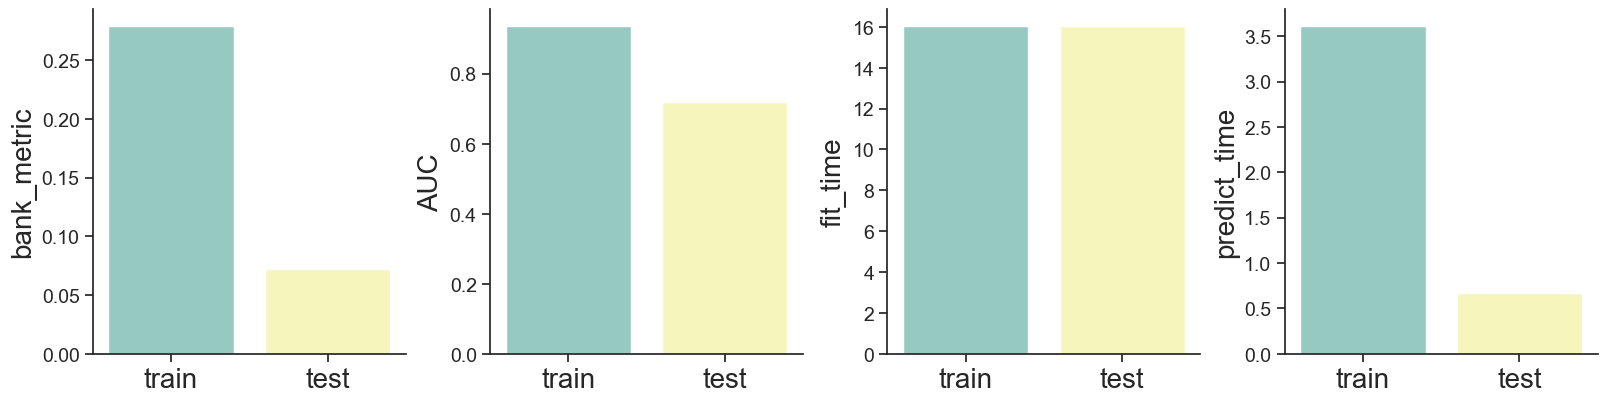

RandomForest_tuned


2023/12/12 19:50:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:50:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:50:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:50:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 117e79dc5d5e40dd9aa6b56df298d69c. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 117e79dc5d5e40dd9aa6b56df298d69c
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '150', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

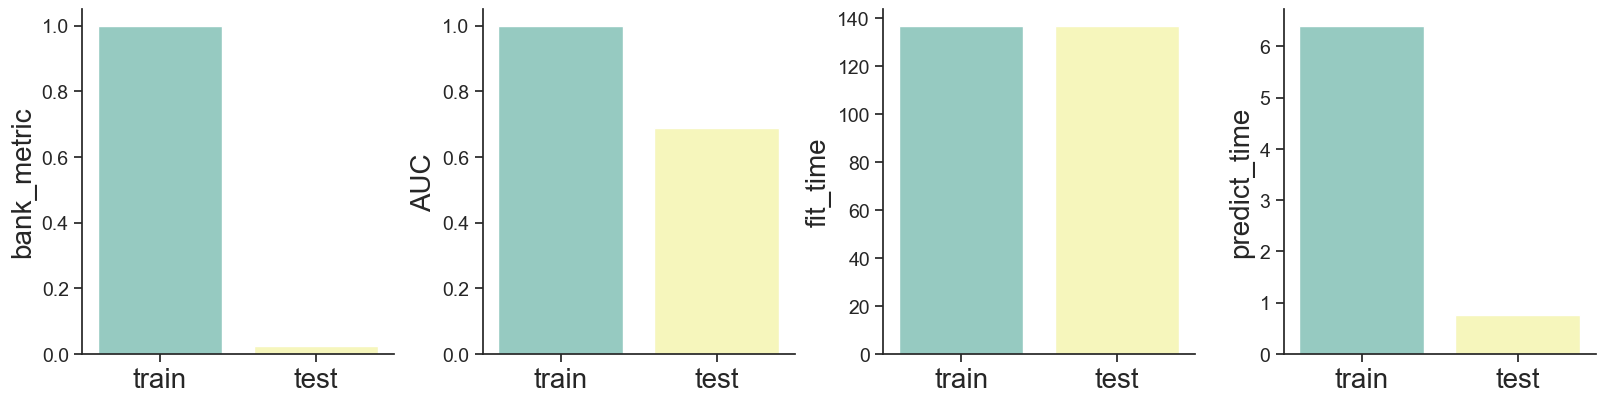

GradientBoosting_tuned


2023/12/12 19:52:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:52:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:52:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:52:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 45618cb4134842e6b80250eb173b02e1. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 45618cb4134842e6b80250eb173b02e1
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

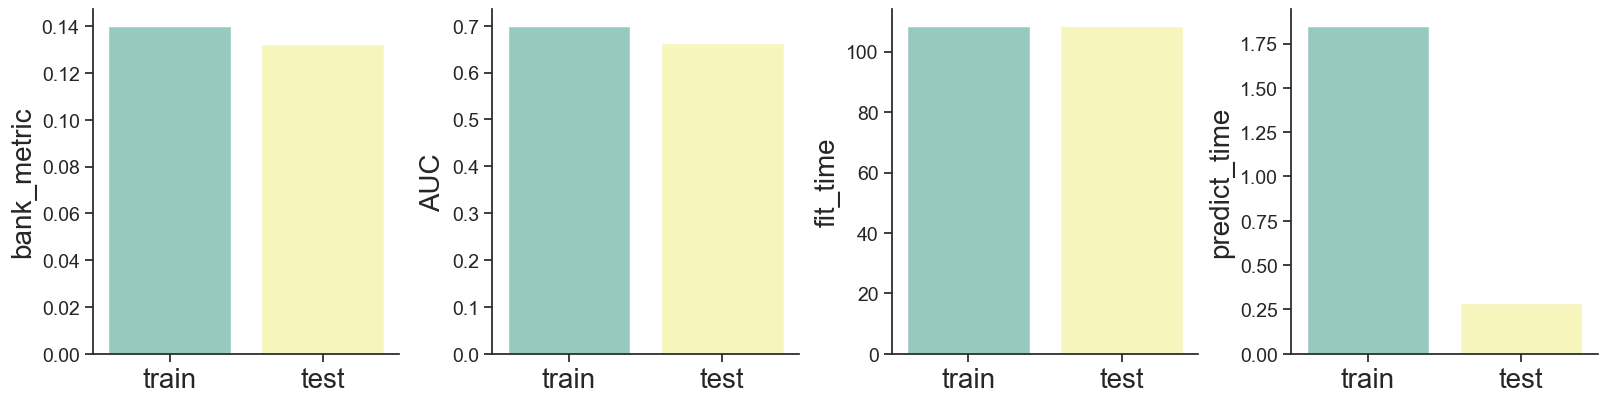

XGBClass_tuned


2023/12/12 19:54:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:54:19 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:54:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:54:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 868078b9e8b24a849850e4e7544cff4f. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 868078b9e8b24a849850e4e7544cff4f
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowski

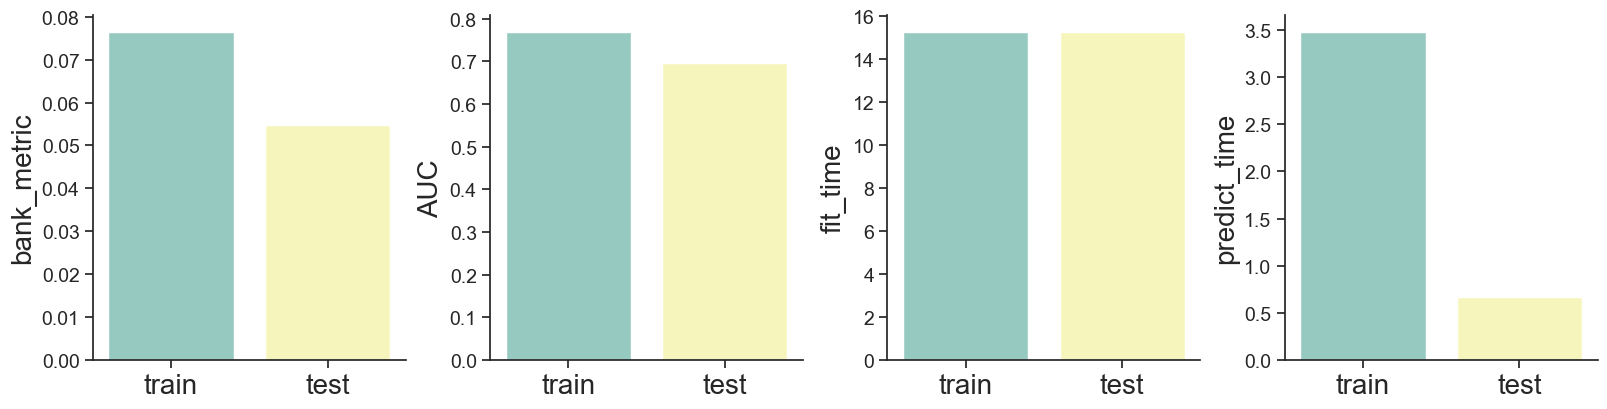

In [586]:
for name, model in dict_of_tuned_models.items():
    print(name)
    evaluation(model)

# Evaluation des prédictions avec un threshold standard

Une fois les hparams optimisé, on évalue les prédictions avec un seuil standard (e.g., 0.5)

In [587]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

In [588]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def prediction_seuil_default(model):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], 0.5)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    Average_precision_score_train = average_precision_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], 0.5)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    Average_precision_score_test = average_precision_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print ("time_pred = ", time_pred_train, time_pred_test)
    print ("auc = ", auc_train, auc_test)
    print ("average_precision_score = ", Average_precision_score_train, Average_precision_score_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print("bank_metric =", bank_train, bank_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "time_pred" : [time_pred_train, time_pred_test],
    "auc" : [auc_train, auc_test],
    "average_precision_score" : [Average_precision_score_train, Average_precision_score_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "bank_metric" : [bank_train, bank_test]})
    
    metrics = ['time_pred', 'auc', 'average_precision_score', 'accuracy', 'precision', 'recall', 'bank_metric']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)
        plt.ylim(0, 1) 

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    return df_result, df_predictions_train, df_predictions_test

RandomForest


2023/12/12 19:54:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:54:39 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:54:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:54:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 181c46478d774363adc642163c143b28. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 181c46478d774363adc642163c143b28
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

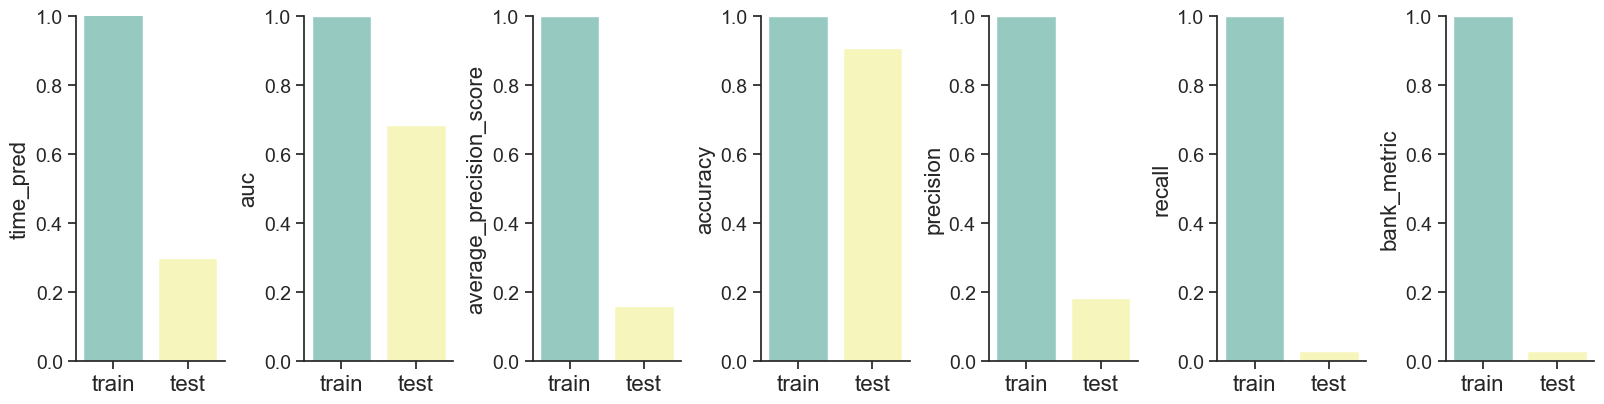

GradientBoosting


2023/12/12 19:56:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:56:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:56:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:56:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8d885483f8a648c3a7e150b5f67361f5. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 8d885483f8a648c3a7e150b5f67361f5
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

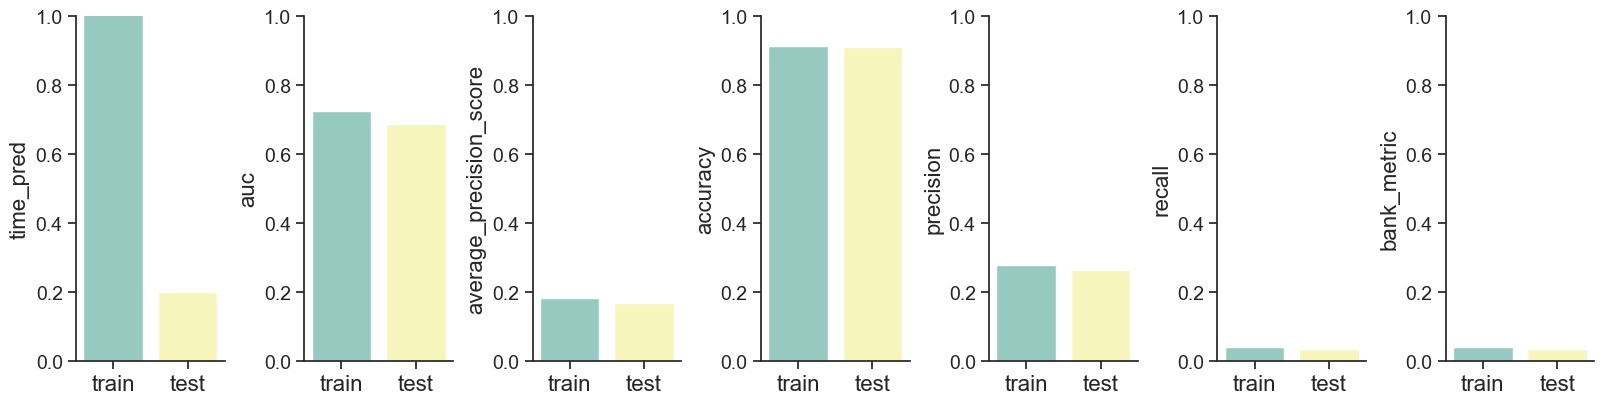

XGBClass


2023/12/12 19:59:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:59:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 19:59:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 19:59:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ab00b66bee624945a1f3b6c6b22be990. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: ab00b66bee624945a1f3b6c6b22be990
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

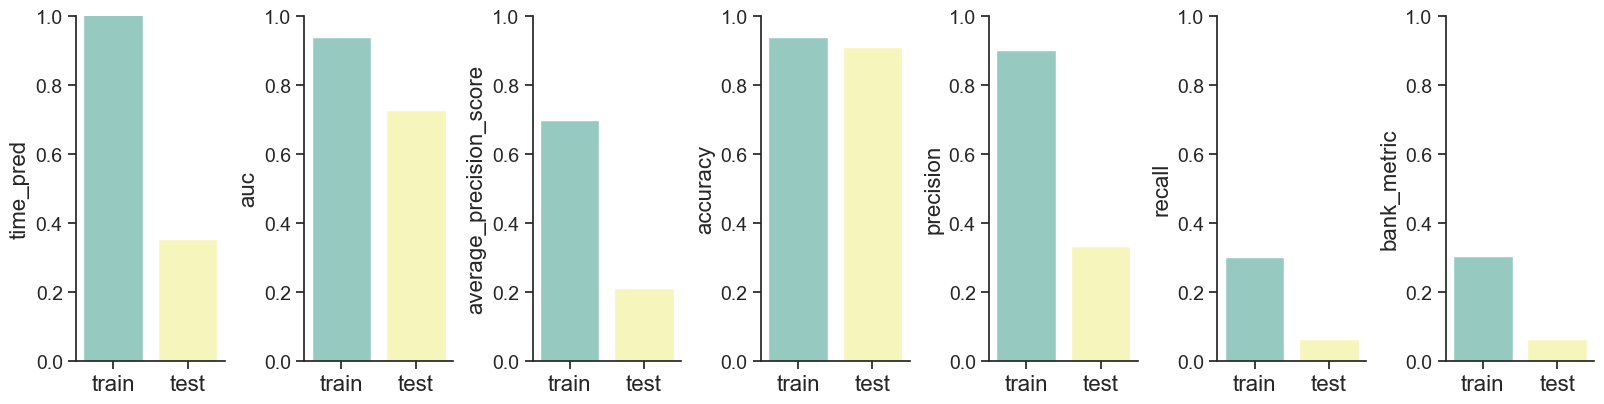

RandomForest_tuned


2023/12/12 20:00:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:00:02 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:00:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:00:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 51f3c03c20ed4fbea571ff69e55f5ac5. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 51f3c03c20ed4fbea571ff69e55f5ac5
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '150', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

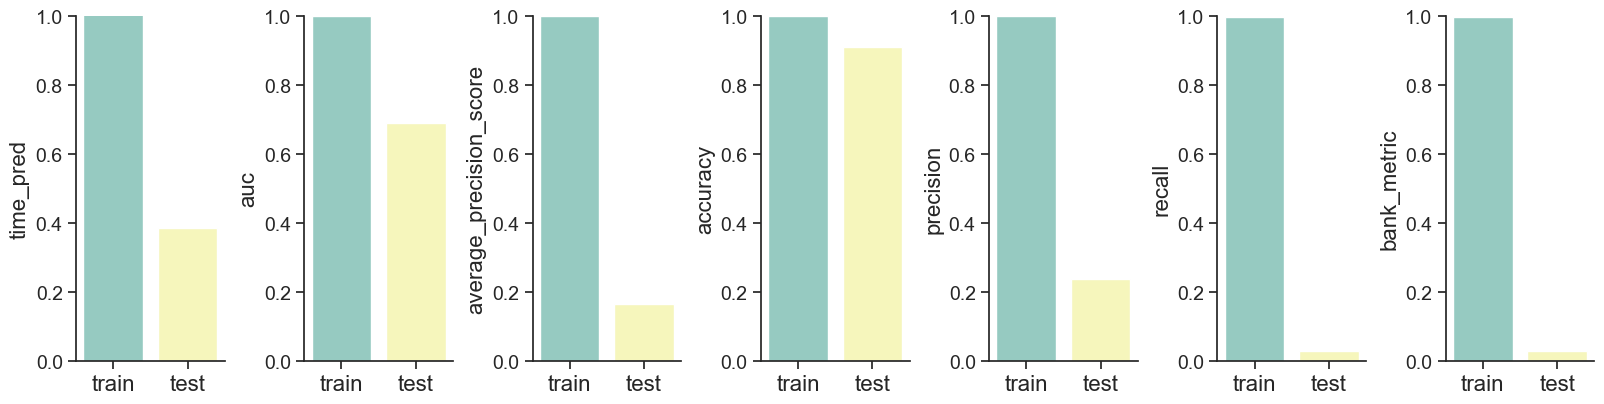

GradientBoosting_tuned


2023/12/12 20:02:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:02:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:02:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:02:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 7530d4bd8db1493d84b4da93505b859d. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 7530d4bd8db1493d84b4da93505b859d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

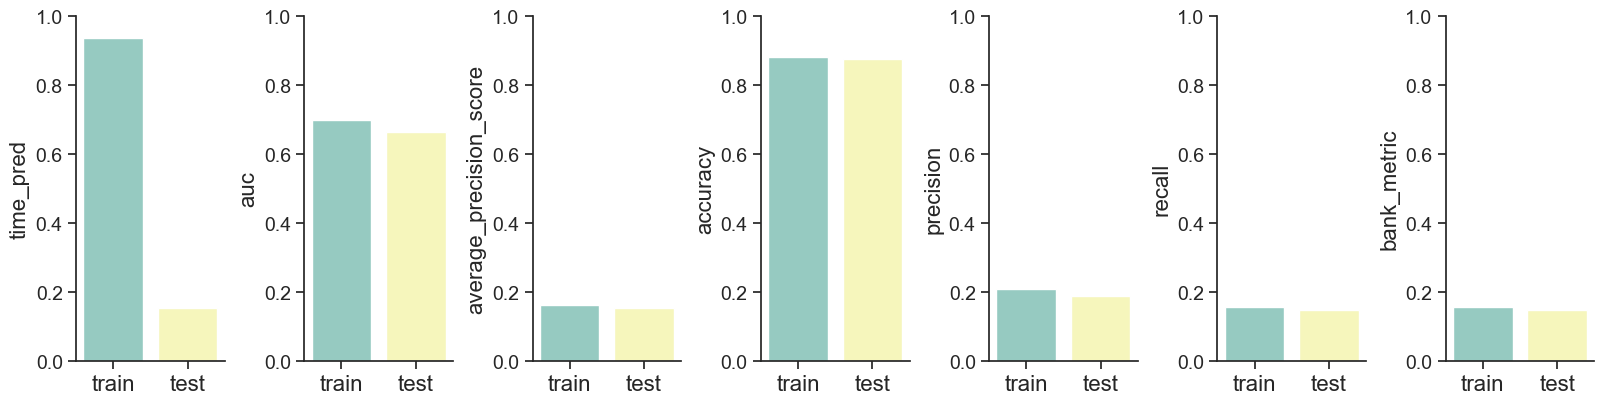

XGBClass_tuned


2023/12/12 20:04:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:04:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:04:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:04:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ce4c0d58fc32492e881e0ebf24596d3b. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: ce4c0d58fc32492e881e0ebf24596d3b
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowski

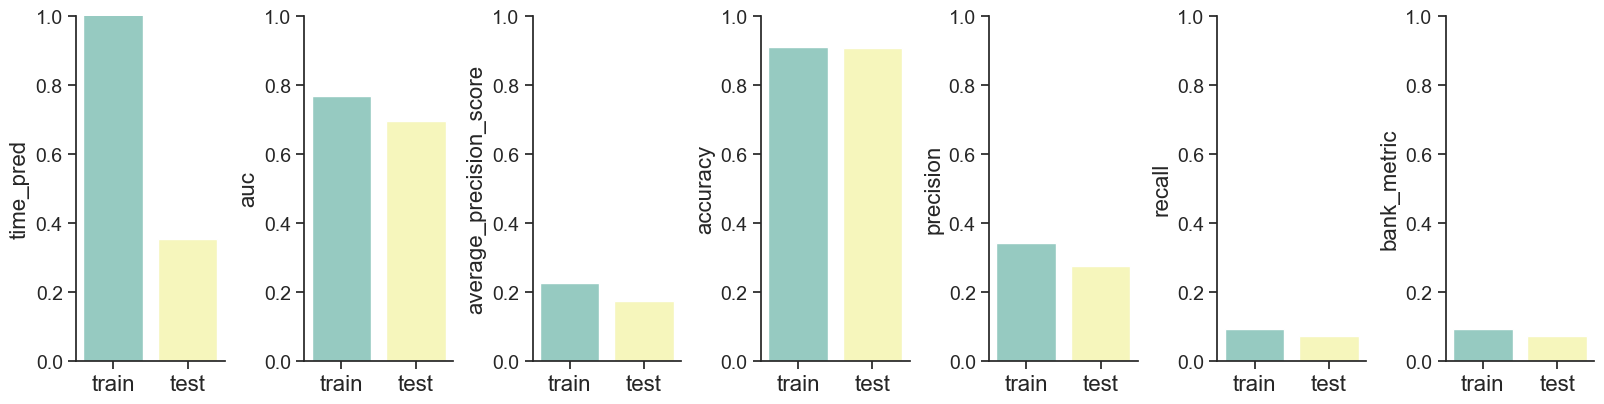

In [589]:
for name, model in dict_of_tuned_models.items():
    print(name)
    prediction_seuil_default(model)

When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Recherche du threshold de prediction optimal (0->1)

Déterminer le meilleur seuil technique pour les meilleurs hparams de l'étape précédente

In [590]:
from sklearn.metrics import f1_score, roc_auc_score

def seuil_solvabilité(model, X, y):
    
    fonction_cout = []
    #fonction_f1score = []
    #fonction_auc = []
    seuils = np.linspace(0.0, 1, 10)

    for seuil in seuils:

        with mlflow.start_run() as run:
            # Score du modèle : n = 0 ou 1
            model.fit(X_train, y_train)
            y_score = pd.DataFrame(model.predict_proba(X)[:, 1])

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score >= seuil).astype("int")
            #y_pred = np.array(y_pred)
        
        print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
        mlflow.end_run()

        # Calcul de l'indice bancaire
        fonction_cout.append(bank_metric(y, y_pred))
        #fonction_f1score.append(f1_score(y_test, y_pred))
        #fonction_auc.append(roc_auc_score(y_test, y_score))
    
    plt.figure(figsize=(5, 2.7), layout='constrained')
    plt.plot(seuils, fonction_cout, label='bank_metric')  # Plot some data on the (implicit) axes.
    #plt.plot(seuils, fonction_f1score, label='f1_score')
    #plt.plot(seuils, fonction_auc, label='roc_auc_score')
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Métriques')
    plt.legend()
    

2023/12/12 20:04:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:04:36 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:04:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:04:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID b4c733e30b974ae08194652500e40fb3. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: b4c733e30b974ae08194652500e40fb3
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:06:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:06:25 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:06:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:06:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 892ece5726eb4adc92e7738a336e0a50. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 892ece5726eb4adc92e7738a336e0a50
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:08:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:08:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:08:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:08:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4c7a259a59b5494a849e95263c344669. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 4c7a259a59b5494a849e95263c344669
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:10:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:10:05 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:10:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:10:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID a3b6f38f7c0e4e049208dc3dd4af74c7. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: a3b6f38f7c0e4e049208dc3dd4af74c7
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:11:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:11:55 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:11:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:11:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c58b085b59a14a87a3dacb85a5a5a2df. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: c58b085b59a14a87a3dacb85a5a5a2df
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:13:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:13:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:13:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:13:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1759d043e4664eae8161bd68f2237c5e. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 1759d043e4664eae8161bd68f2237c5e
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:15:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:15:35 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:15:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:15:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID cf966e530b7243799fdb8061ecf64ffb. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: cf966e530b7243799fdb8061ecf64ffb
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:17:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:17:25 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:17:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:17:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 66b50db65cbe4a48a0cfe255b8a32a6f. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 66b50db65cbe4a48a0cfe255b8a32a6f
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:19:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:19:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:19:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:19:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 7c17320542004807970aeecb517a2c9a. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 7c17320542004807970aeecb517a2c9a
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

2023/12/12 20:21:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:21:05 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 20:21:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 20:21:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3a555343793746baa6e3f2b6e032db07. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'imputer\', SimpleImputer(strategy=\'media

run_id: 3a555343793746baa6e3f2b6e032db07
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

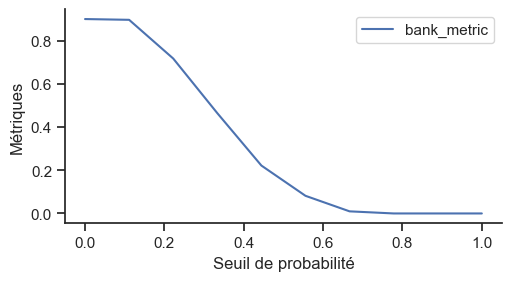

In [591]:
seuil_solvabilité(GradientBoosting_tuned, X_test, y_test)

In [592]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def prediction_seuil_optimal(model, seuil):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], seuil)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    Average_precision_score_train = average_precision_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], seuil)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    Average_precision_score_test = average_precision_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print ("time_pred = ", time_pred_train, time_pred_test)
    print ("auc = ", auc_train, auc_test)
    print ("average_precision_score = ", Average_precision_score_train, Average_precision_score_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print("bank_metric =", bank_train, bank_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "time_pred" : [time_pred_train, time_pred_test],
    "auc" : [auc_train, auc_test],
    "average_precision_score" : [Average_precision_score_train, Average_precision_score_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "bank_metric" : [bank_train, bank_test]})
    
    metrics = ['time_pred', 'auc', 'average_precision_score', 'accuracy', 'precision', 'recall', 'bank_metric']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set2")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)
        plt.ylim(0, 1) 

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    cm = confusion_matrix(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    plot_roc_curve(df_predictions_test['y_test'], df_predictions_test["y_proba_test"])
    print(f'model 1 AUC score: {roc_auc_score(df_predictions_test['y_test'], df_predictions_test["y_proba_test"])}')
    
    return df_predictions_test, df_predictions_train
    

SyntaxError: f-string: unmatched '[' (345088802.py, line 91)

2023/12/12 15:57:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 15:57:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 15:57:45 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 15:57:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 15:57:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: d2d9d5934b5d4d0ca2fa2e83924a7390
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

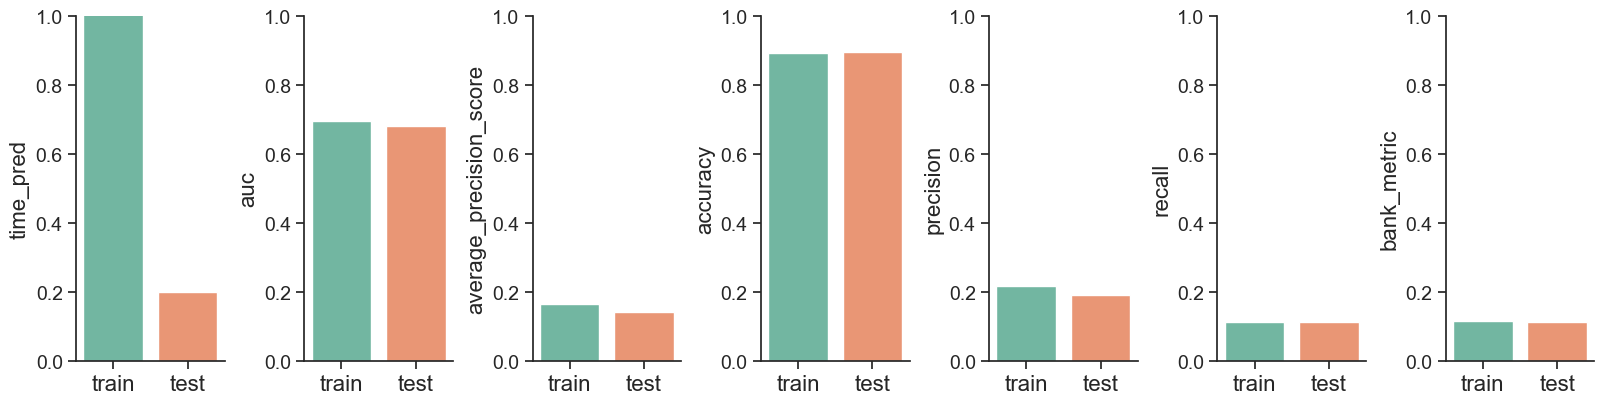

(        y_test  y_proba_test  y_pred_test
 78573        0      0.193811            0
 90678        0      0.328831            0
 71774        0      0.217206            0
 43932        0      0.102035            0
 198917       0      0.235529            0
 ...        ...           ...          ...
 196697       0      0.324913            0
 246761       0      0.406244            0
 149362       0      0.361659            0
 298119       0      0.147706            0
 41966        0      0.272097            0
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.254721             0
 49661         0       0.210834             0
 75800         0       0.165687             0
 31542         0       0.143650             0
 29871         0       0.199487             0
 ...         ...            ...           ...
 284483        0       0.221885             0
 93999         0       0.592681             1
 236785        0       0.354682           

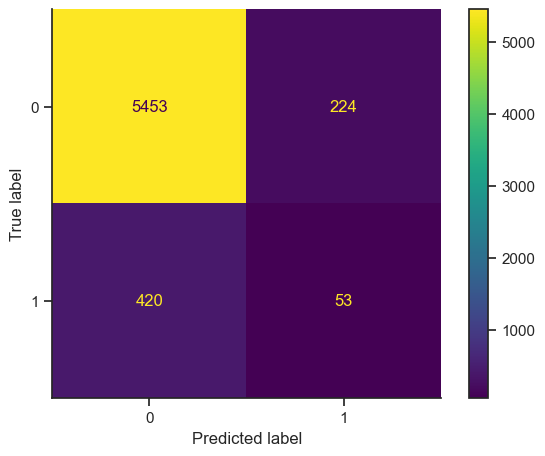

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.5)

2023/12/12 15:59:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 15:59:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 15:59:45 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 15:59:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 15:59:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 8473d8d5799a4847ad941873c1bd24ca
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

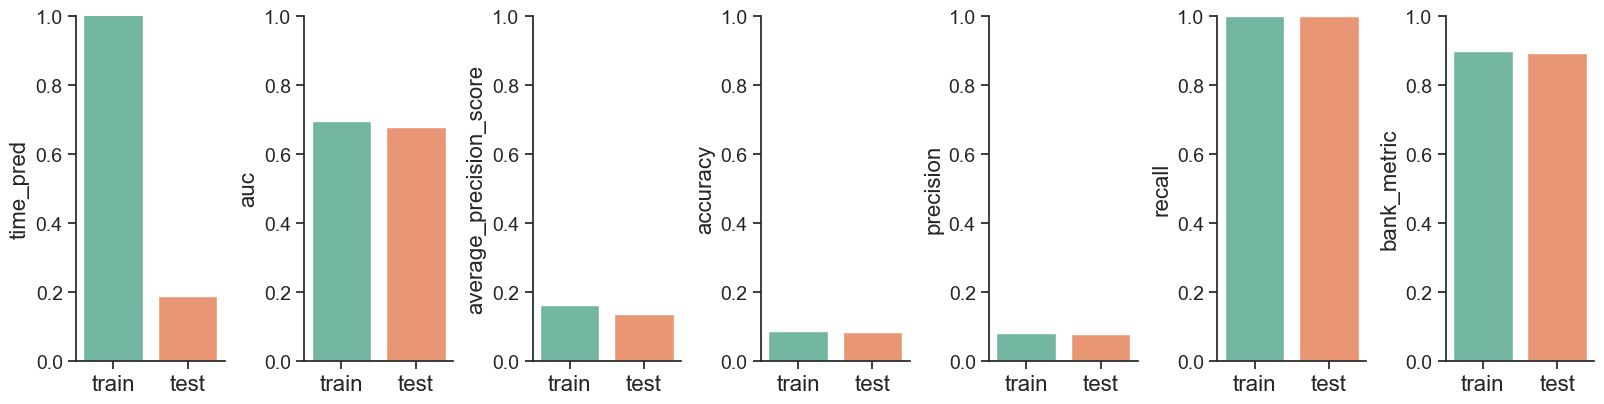

(        y_test  y_proba_test  y_pred_test
 78573        0      0.206741            1
 90678        0      0.321135            1
 71774        0      0.210567            1
 43932        0      0.156931            1
 198917       0      0.258522            1
 ...        ...           ...          ...
 196697       0      0.337038            1
 246761       0      0.394265            1
 149362       0      0.344812            1
 298119       0      0.198962            1
 41966        0      0.279116            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.242556             1
 49661         0       0.248459             1
 75800         0       0.156044             1
 31542         0       0.155213             1
 29871         0       0.220559             1
 ...         ...            ...           ...
 284483        0       0.215863             1
 93999         0       0.568708             1
 236785        0       0.324812           

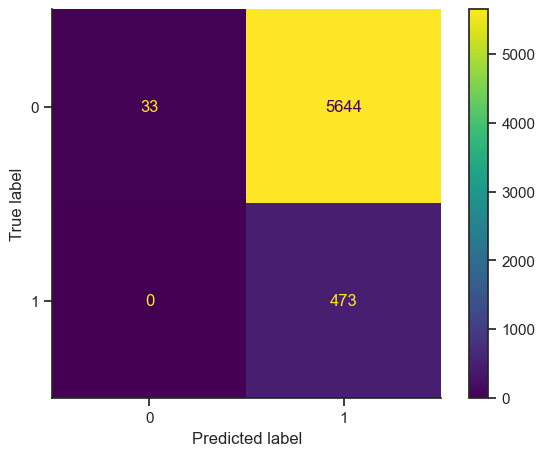

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.07)

2023/12/12 16:01:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:01:46 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:01:46 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:01:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:01:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: ac3d2b88cdb14056a637af13fa52e3dc
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

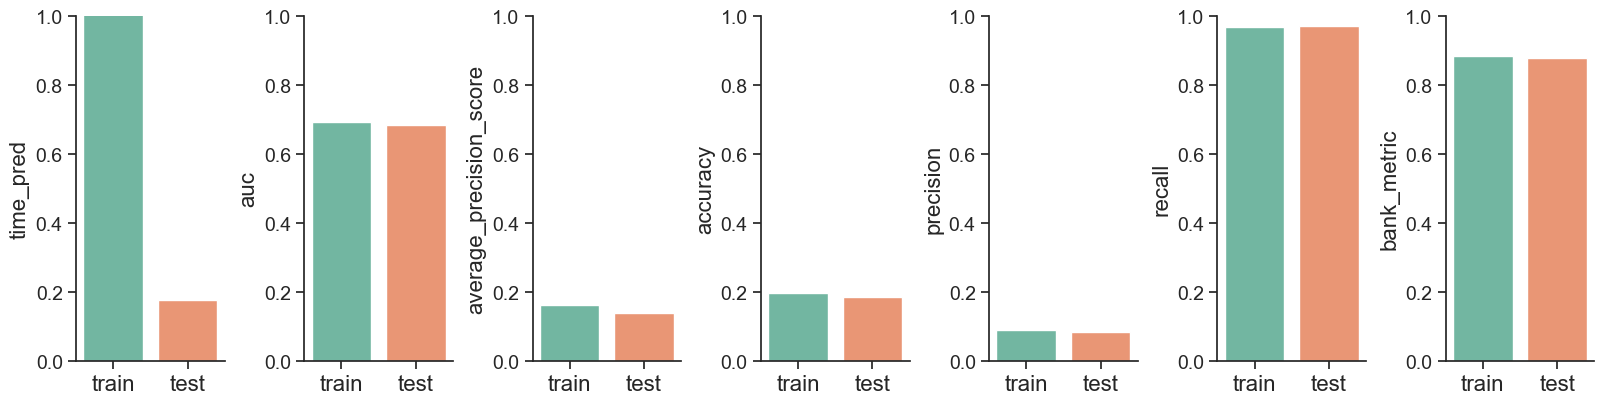

(        y_test  y_proba_test  y_pred_test
 78573        0      0.206016            1
 90678        0      0.338764            1
 71774        0      0.179249            1
 43932        0      0.134094            1
 198917       0      0.310012            1
 ...        ...           ...          ...
 196697       0      0.406740            1
 246761       0      0.428961            1
 149362       0      0.369893            1
 298119       0      0.194457            1
 41966        0      0.287166            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.224078             1
 49661         0       0.306661             1
 75800         0       0.116081             0
 31542         0       0.111628             0
 29871         0       0.241080             1
 ...         ...            ...           ...
 284483        0       0.157394             1
 93999         0       0.626939             1
 236785        0       0.385673           

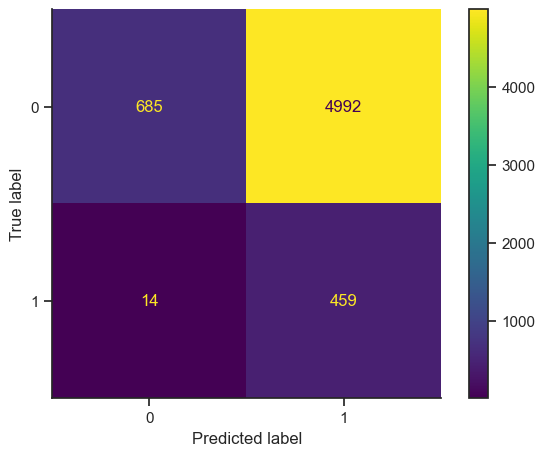

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.12)

2023/12/12 16:03:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:03:50 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:03:50 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:03:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:03:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 80e48c8f849c4f9fa8540dd0e5c99dfa
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

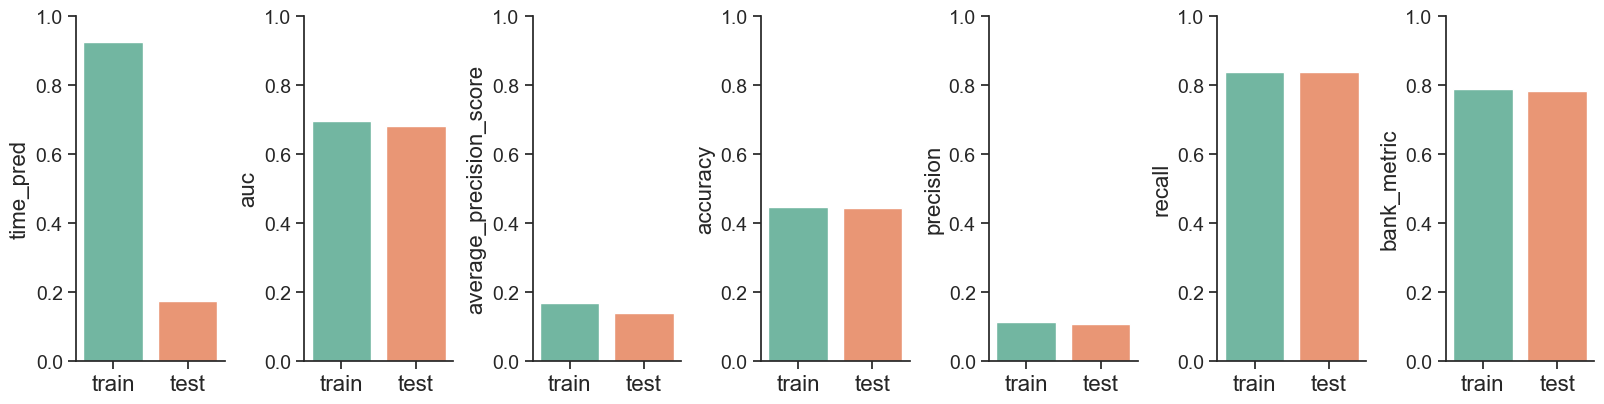

(        y_test  y_proba_test  y_pred_test
 78573        0      0.196345            0
 90678        0      0.321003            1
 71774        0      0.211301            1
 43932        0      0.184214            0
 198917       0      0.279505            1
 ...        ...           ...          ...
 196697       0      0.331554            1
 246761       0      0.430994            1
 149362       0      0.385745            1
 298119       0      0.195545            0
 41966        0      0.290798            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.268491             1
 49661         0       0.219134             1
 75800         0       0.123379             0
 31542         0       0.136427             0
 29871         0       0.217661             1
 ...         ...            ...           ...
 284483        0       0.231543             1
 93999         0       0.571577             1
 236785        0       0.440043           

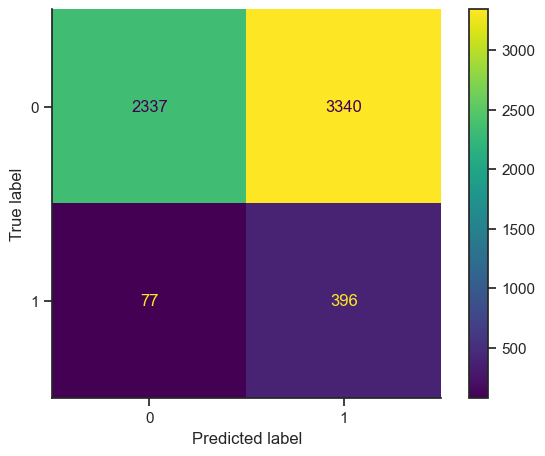

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.2)

2023/12/12 16:05:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:05:50 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:05:50 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:05:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:05:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 8948536a14f245c3b7e9998f0bebc51c
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

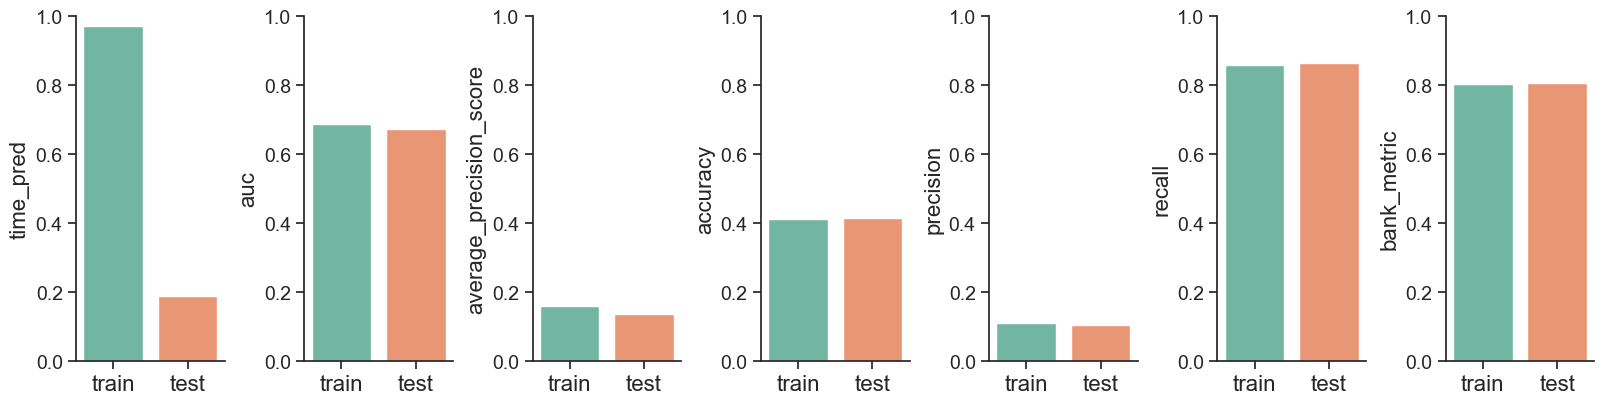

(        y_test  y_proba_test  y_pred_test
 78573        0      0.250731            1
 90678        0      0.494367            1
 71774        0      0.197744            0
 43932        0      0.156079            0
 198917       0      0.266926            1
 ...        ...           ...          ...
 196697       0      0.403308            1
 246761       0      0.431862            1
 149362       0      0.337314            1
 298119       0      0.161799            0
 41966        0      0.290182            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.247467             1
 49661         0       0.290355             1
 75800         0       0.175971             0
 31542         0       0.152457             0
 29871         0       0.270699             1
 ...         ...            ...           ...
 284483        0       0.261172             1
 93999         0       0.612848             1
 236785        0       0.347814           

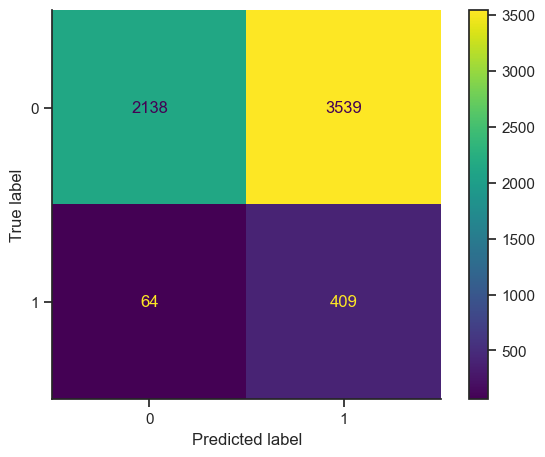

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.21)

2023/12/12 16:07:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:07:53 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:07:53 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:07:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:07:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 8433775248474f8b90abfe465f8318f1
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

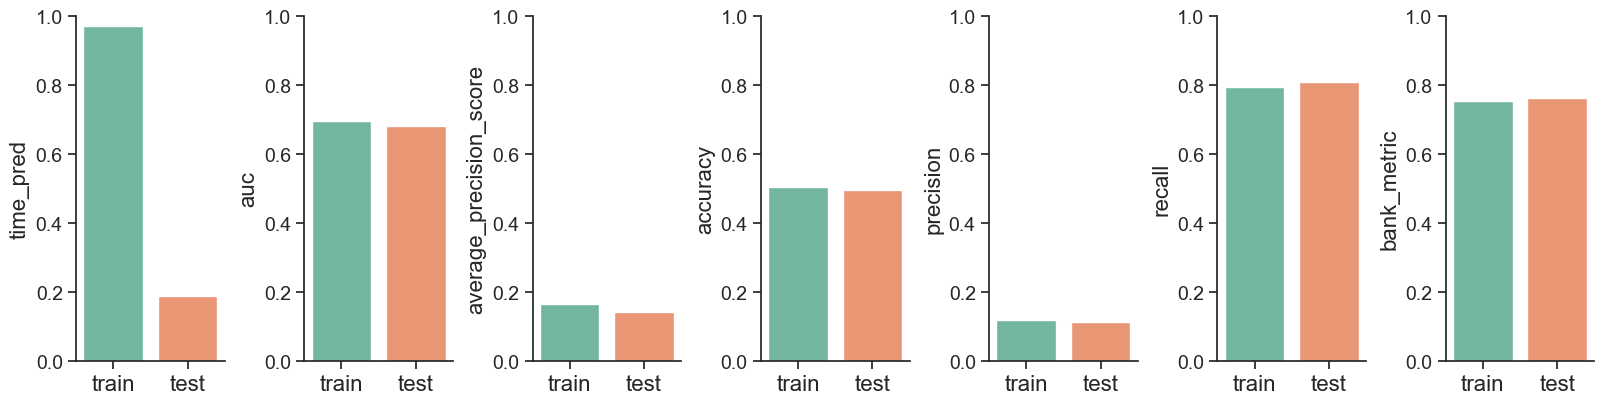

(        y_test  y_proba_test  y_pred_test
 78573        0      0.232550            1
 90678        0      0.300870            1
 71774        0      0.165359            0
 43932        0      0.167384            0
 198917       0      0.288273            1
 ...        ...           ...          ...
 196697       0      0.390415            1
 246761       0      0.429488            1
 149362       0      0.380079            1
 298119       0      0.136301            0
 41966        0      0.295076            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.283666             1
 49661         0       0.199004             0
 75800         0       0.166194             0
 31542         0       0.116298             0
 29871         0       0.251919             1
 ...         ...            ...           ...
 284483        0       0.225300             1
 93999         0       0.554269             1
 236785        0       0.422810           

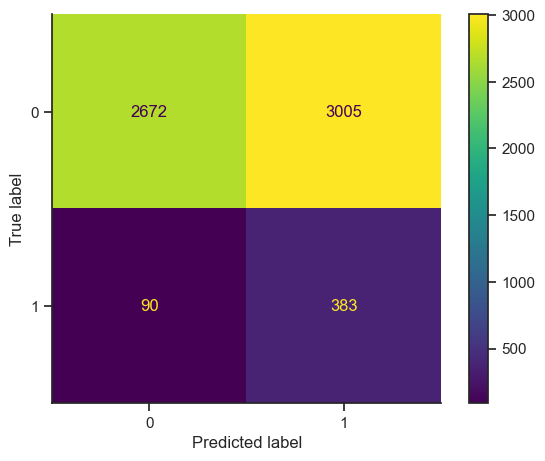

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.22)


2023/12/12 16:09:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:09:56 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:09:56 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:09:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:09:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 22abcf460acf487390d0631ee9b6b977
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

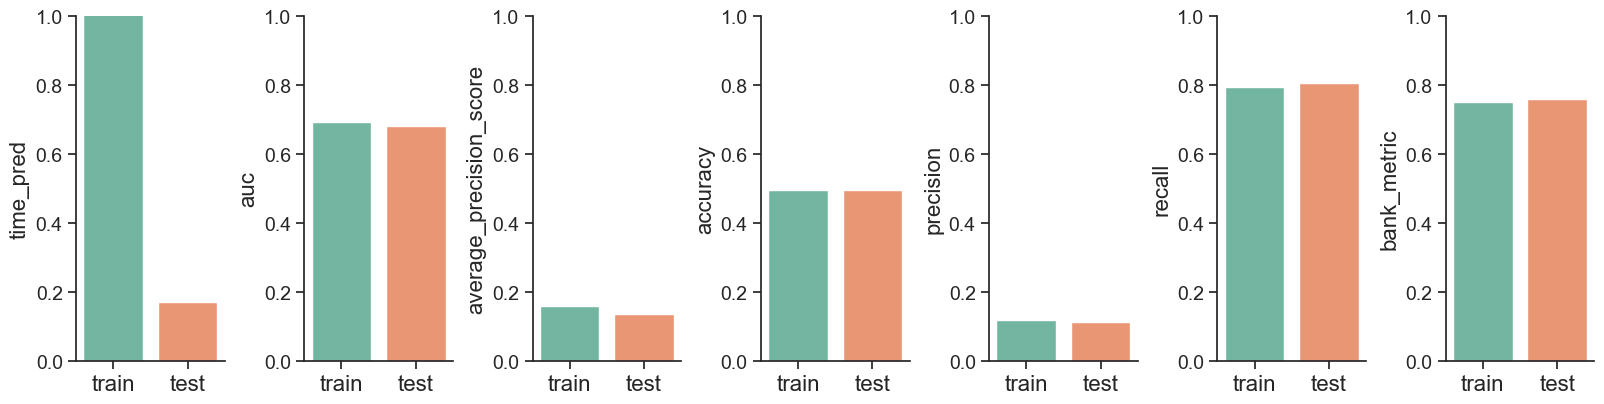

(        y_test  y_proba_test  y_pred_test
 78573        0      0.233976            1
 90678        0      0.385747            1
 71774        0      0.194556            0
 43932        0      0.167975            0
 198917       0      0.321279            1
 ...        ...           ...          ...
 196697       0      0.361717            1
 246761       0      0.481429            1
 149362       0      0.375347            1
 298119       0      0.192203            0
 41966        0      0.299192            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.264628             1
 49661         0       0.223869             0
 75800         0       0.165545             0
 31542         0       0.142406             0
 29871         0       0.293522             1
 ...         ...            ...           ...
 284483        0       0.240963             1
 93999         0       0.647534             1
 236785        0       0.426550           

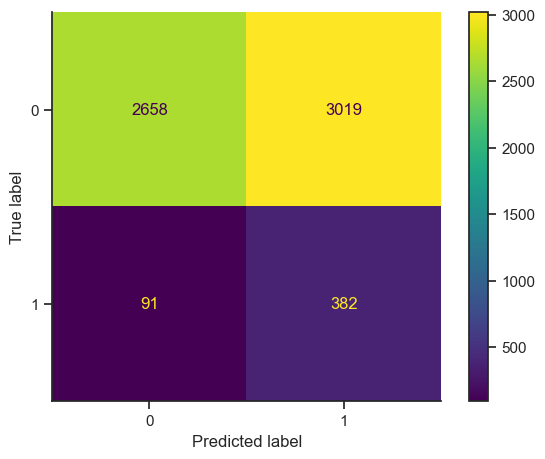

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.23)


2023/12/12 16:11:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:11:58 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:11:58 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:11:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:12:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: bd6f39707d7f4809a8be3fe33fc7a580
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

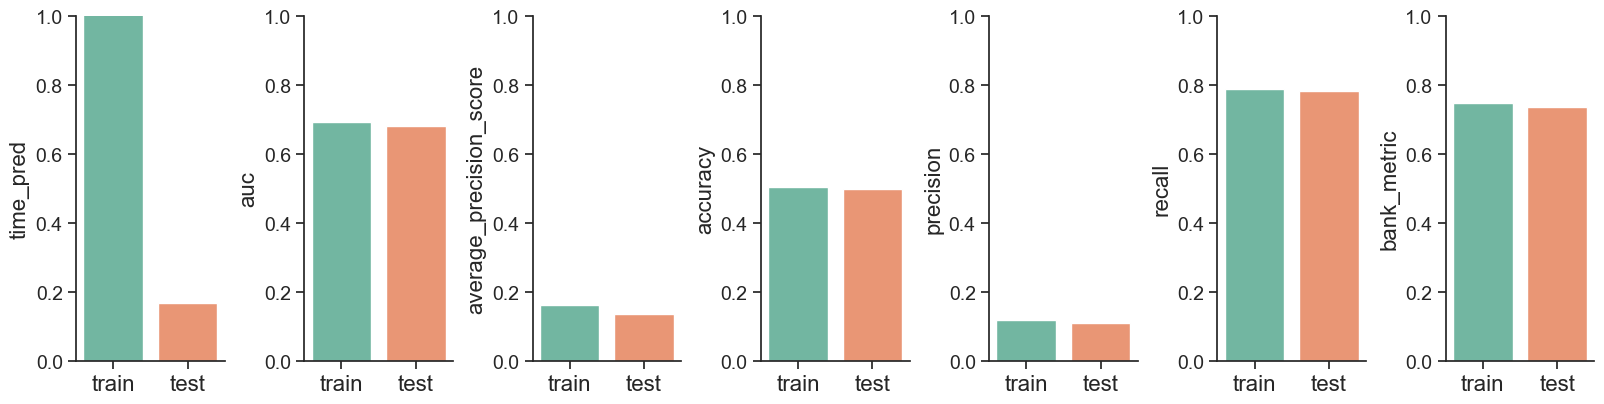

(        y_test  y_proba_test  y_pred_test
 78573        0      0.257835            1
 90678        0      0.343483            1
 71774        0      0.185206            0
 43932        0      0.180245            0
 198917       0      0.320930            1
 ...        ...           ...          ...
 196697       0      0.367998            1
 246761       0      0.476675            1
 149362       0      0.385617            1
 298119       0      0.201967            0
 41966        0      0.282126            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.302311             1
 49661         0       0.250130             1
 75800         0       0.185719             0
 31542         0       0.173045             0
 29871         0       0.260297             1
 ...         ...            ...           ...
 284483        0       0.222013             0
 93999         0       0.621539             1
 236785        0       0.446165           

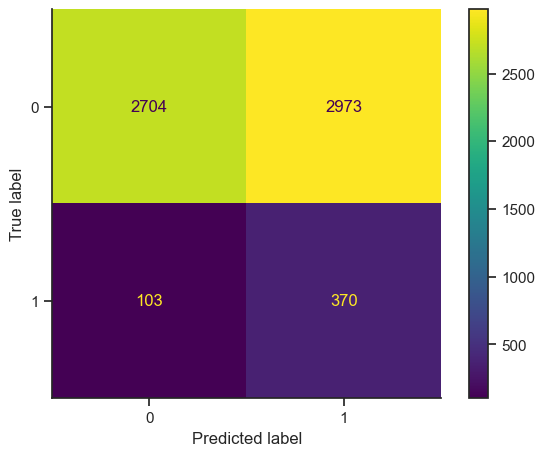

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.24)


2023/12/12 16:13:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:13:54 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:13:54 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:13:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:13:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: bbc113acdd684aa2bf1cbcb70b062d38
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

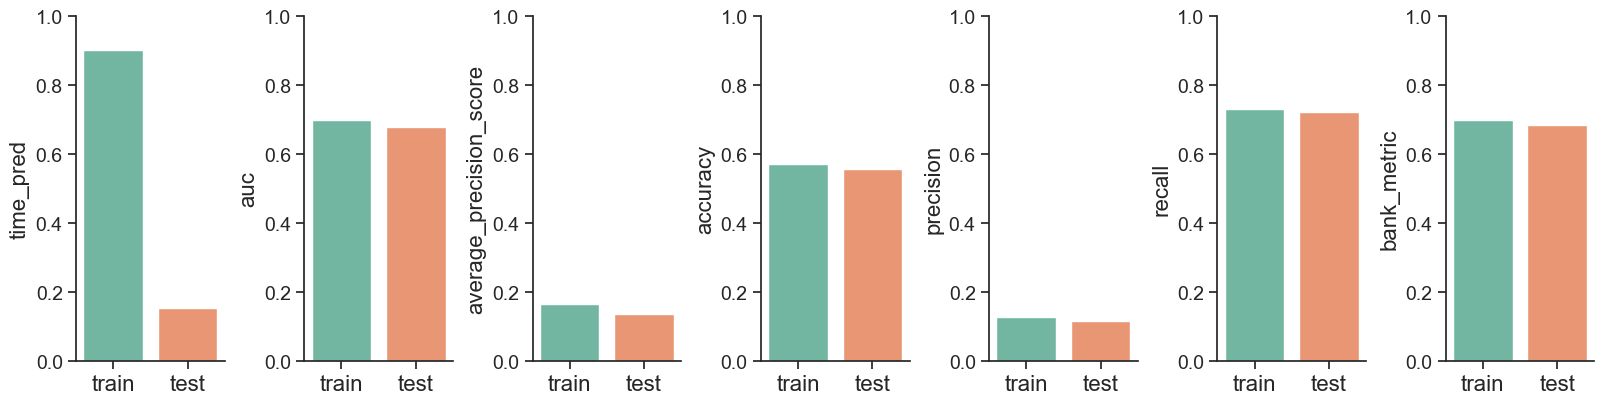

(        y_test  y_proba_test  y_pred_test
 78573        0      0.197976            0
 90678        0      0.347028            1
 71774        0      0.172945            0
 43932        0      0.171499            0
 198917       0      0.301261            1
 ...        ...           ...          ...
 196697       0      0.366891            1
 246761       0      0.440760            1
 149362       0      0.400115            1
 298119       0      0.141374            0
 41966        0      0.286732            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.291230             1
 49661         0       0.285269             1
 75800         0       0.126916             0
 31542         0       0.128444             0
 29871         0       0.221526             0
 ...         ...            ...           ...
 284483        0       0.233098             0
 93999         0       0.563118             1
 236785        0       0.403066           

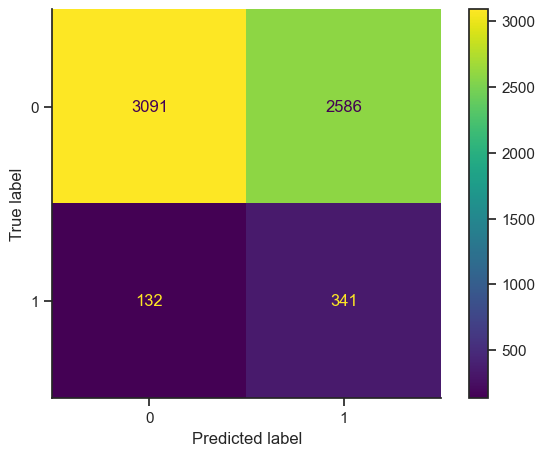

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.25)

2023/12/12 16:15:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:15:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:15:45 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:15:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:15:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 50b7cb50daf24b97b6ee36d78548fb60
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

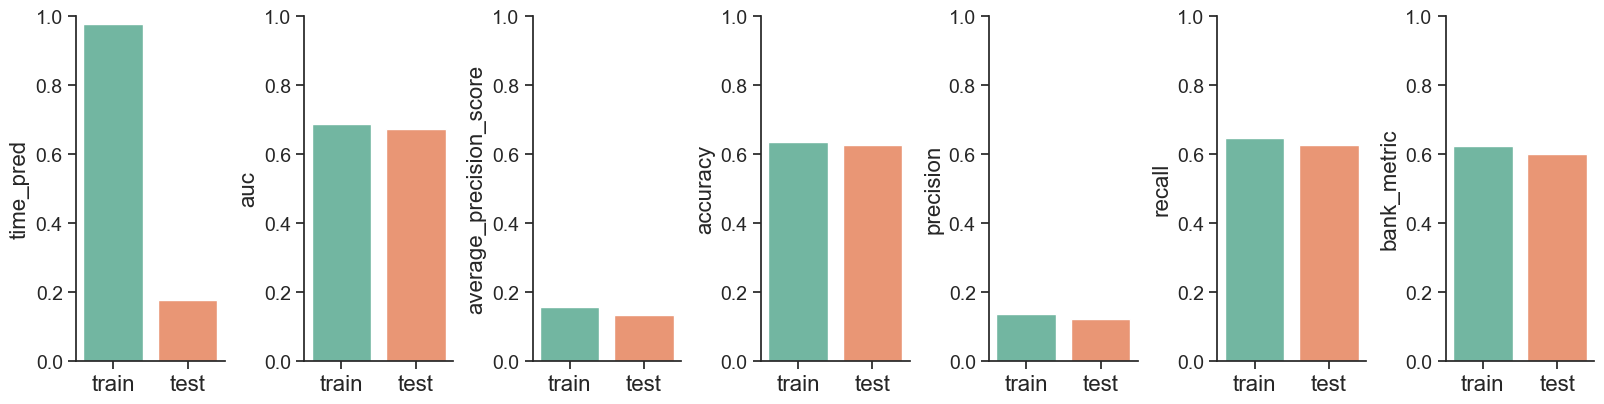

(        y_test  y_proba_test  y_pred_test
 78573        0      0.216905            0
 90678        0      0.382739            1
 71774        0      0.221854            0
 43932        0      0.162735            0
 198917       0      0.321419            1
 ...        ...           ...          ...
 196697       0      0.346664            1
 246761       0      0.461057            1
 149362       0      0.400940            1
 298119       0      0.186544            0
 41966        0      0.260438            0
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 266879        0       0.297299             0
 49661         0       0.274873             0
 75800         0       0.165328             0
 31542         0       0.190845             0
 29871         0       0.321562             1
 ...         ...            ...           ...
 284483        0       0.230120             0
 93999         0       0.583132             1
 236785        0       0.454031           

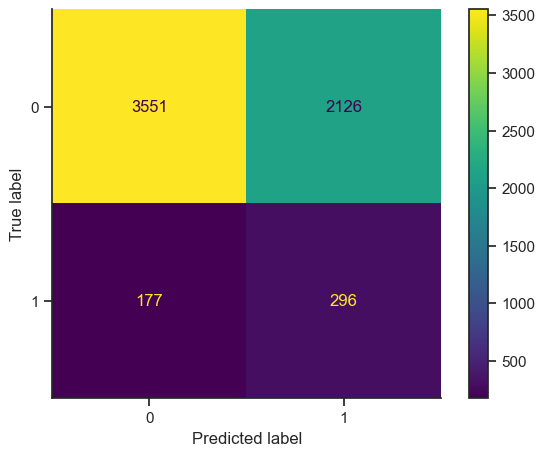

In [ ]:
prediction_seuil_optimal(GradientBoosting_tuned, 0.3)

When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

# predict probabilities
lr_probs = pd.DataFrame(GradientBoosting_tuned.predict_proba(X_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = transform_treshold(lr_probs, 0.25)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

# predict probabilities
y_probs = pd.DataFrame(GradientBoosting_tuned.predict_proba(X_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]



# Modèle optimal et conclusions

Le gradient boosting Classifier donne de bons resultats. Sur la base de notre métric banquaire, nous choisissons un seuil strict, à 0.25, qui permet une bonne prédiction des remboursements et (surtout) une très bonne prédiction des défauts de remboursement dans la clientèle d'étude.

Nous allons maintenant nous concentrer sur le dashboard et les informations utiles à afficher pour le client.

In [ ]:
#Model final 
import mlflow

with mlflow.start_run() as run:
    
    GradientBoosting_tuned.fit(X_train, y_train)
    y_proba = GradientBoosting_tuned.predict_proba(X_valid)[:, 1]
    df_final = pd.DataFrame()
    df_final["y_valid"] = y_valid
    df_final['y_proba'] = y_proba
    y_pred = transform_treshold(df_final["y_proba"], 0.25)
    df_final['y_pred'] = y_pred

print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
mlflow.end_run()

2023/12/12 16:17:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:17:38 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:17:38 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 16:17:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 16:17:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: d1f9342cfdfd4ae5a40a33fe0abab231
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '50', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False

In [ ]:
GradientBoosting_tuned.score(X_valid, y_valid)

0.8869918699186992

# Features importances

1. Que signifie SHAP ?
SHAP signifie SHapley Additive exPlanations et utilise l'approche de la théorie des jeux pour expliquer les prédictions des modèles.
2. Comment fonctionne la bibliothèque SHAP, Quelles sont les valeurs SHAP, Comment les valeurs SHAP sont-elles générées ?
SHAP part d'une valeur de base pour la prédiction, basée sur des connaissances préalables, puis essaie les caractéristiques des données une par une pour comprendre l'impact de l'introduction de cette caractéristique sur notre valeur de base afin d'établir la prédiction finale. Il prend même en compte l'ordre d'introduction des caractéristiques ainsi que l'interaction entre les caractéristiques, ce qui nous aide à mieux comprendre les performances du modèle. Au cours de ce processus, il enregistre les valeurs SHAP qui seront utilisées ultérieurement pour tracer et expliquer les prédictions.
Ces valeurs SHAP sont générées pour chaque caractéristique des données et montrent généralement leur impact sur la prédiction. SHAP possède de nombreux objets explicatifs qui utilisent différentes approches pour générer des valeurs SHAP en fonction de l'algorithme utilisé. Nous les avons énumérés plus loin en donnant quelques explications à leur sujet.
3. Comment interpréter les prédictions à l'aide de SHAP ?
Charger la bibliothèque shap (l'importer et l'initialiser).
Créer un objet Explainer.
Générer des valeurs SHAP pour les exemples de données en utilisant l'objet explainer.
Créer diverses visualisations à l'aide de ces valeurs shap pour expliquer les prédictions.

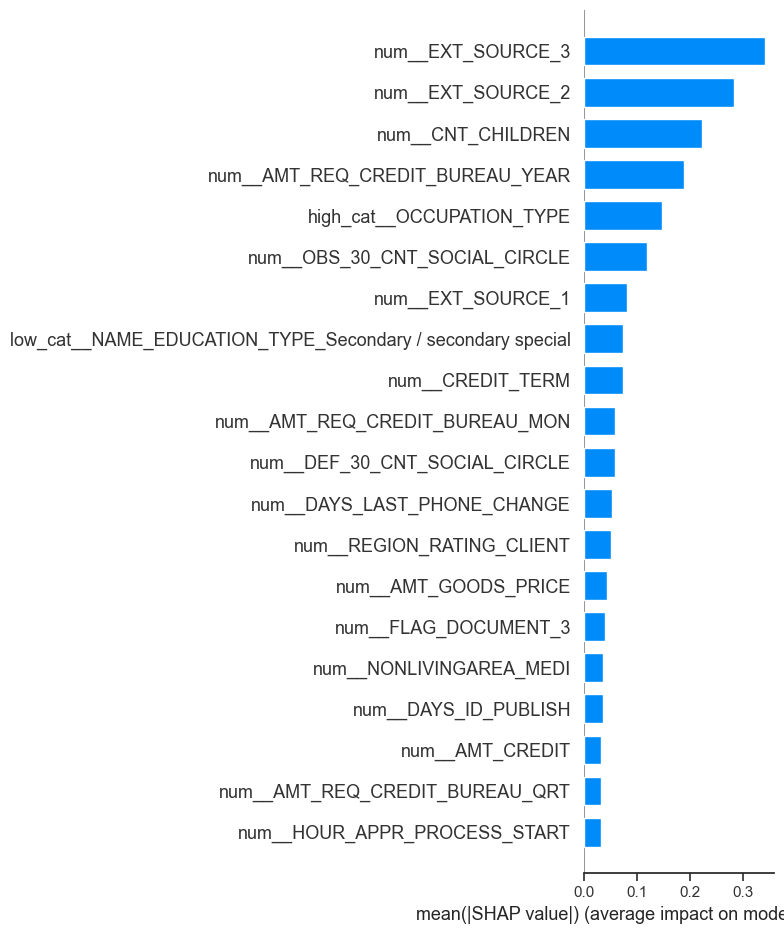

In [ ]:
import shap
from shap import TreeExplainer
#set_config(transform_output="pandas")
#load JS vis in the notebook

shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(GradientBoosting_tuned['model'])

#apply the preprocessing to x_test
observations = GradientBoosting_tuned['preprocessor'].transform(X_valid)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar")
#shap.plots.bar(shap_values, max_display=12)

#plot the feature importance
#shap.summary_plot(shap_values[1], observations, plot_type="bar")

Local bar plot
Le passage d'une ligne de valeurs SHAP à la fonction de tracé en barres crée un tracé local de l'importance de l'élément, où les barres représentent les valeurs SHAP pour chaque élément. Notez que les valeurs des features sont affichées en gris à gauche des noms des features.

In [ ]:
random_idx = np.random.randint(len(observations))
random_idx

5771

In [ ]:
shap_explainer_values = explainer(observations, y_valid)
type(shap_explainer_values)

shap._explanation.Explanation

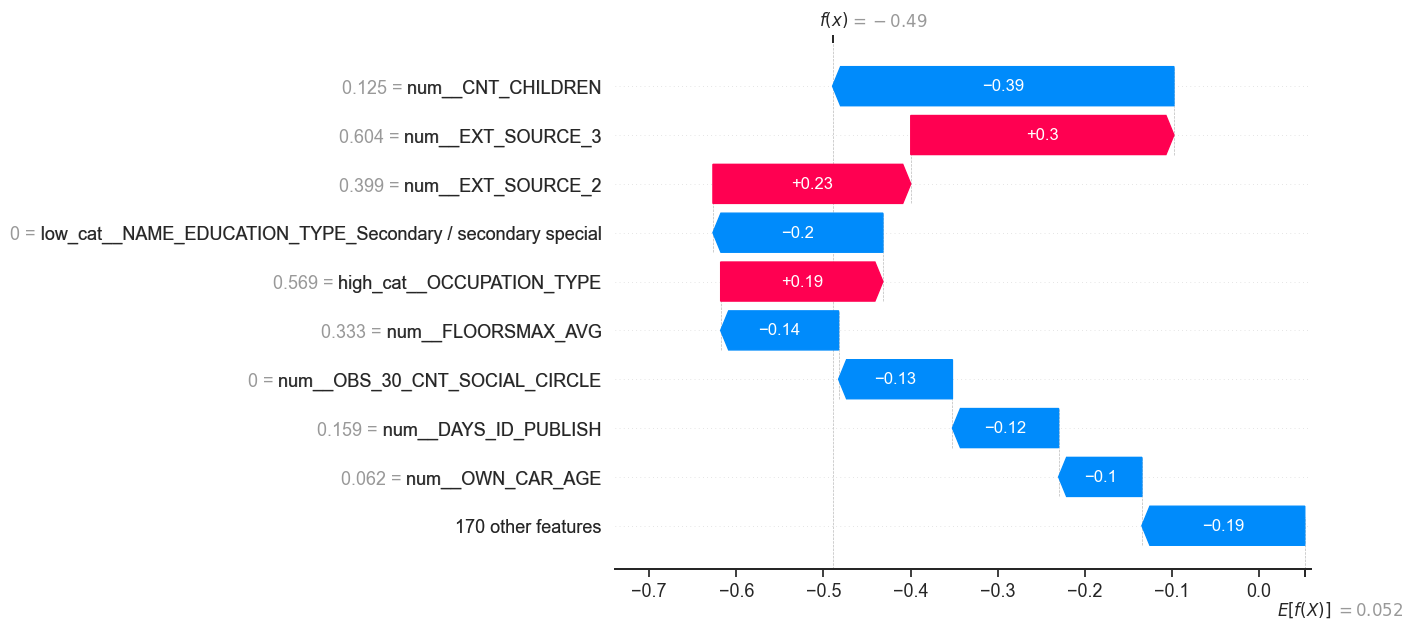

In [ ]:
from shap import waterfall_plot

shap.waterfall_plot(shap_explainer_values[random_idx])

# Evaluation du Data drift avec Evidently

Evidently est une bibliothèque Python open-source destinée aux data scientists et aux ingénieurs ML.
Elle permet d'évaluer, de tester et de contrôler les données et les modèles de ML, de la validation à la production. Elle fonctionne avec des données tabulaires, textuelles et des embeddings.

In [ ]:
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [ ]:
print(X_train_evidently.shape)
print(X_test_evidently.shape)
print(X_valid_evidently.shape) 

print(y_train_evidently.shape) 
print(y_test_evidently.shape)
print(y_valid_evidently.shape) 

(49201, 125)
(6150, 125)
(6150, 125)
(49201,)
(6150,)
(6150,)


In [ ]:
GradientBoosting_tuned["preprocessor"].fit(X_train, y_train)

X_train_transf = pd.DataFrame(GradientBoosting_tuned["preprocessor"].transform(X_train_evidently),
             columns=GradientBoosting_tuned["preprocessor"].get_feature_names_out(),
             index=X_train_evidently.index)

X_test_transf = pd.DataFrame(GradientBoosting_tuned["preprocessor"].transform(X_test_evidently),
             columns=GradientBoosting_tuned["preprocessor"].get_feature_names_out(),
             index=X_test_evidently.index)


2023/12/12 17:31:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dfb848ec119341b1b5340803ed9ca052', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/12 17:31:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 17:31:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '643220a2d97946128faa49fd2ab70830', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/12 17:31:34 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 17:31:34 WARNING mlflow.sklearn: Failed to infer model signature: Unabl

In [ ]:
#Get a report, Get a visual report to explore the feature distribution drift in detail:

data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=X_test_transf.sample(frac = 0.2), reference_data=X_train_transf.sample(frac = 0.2), column_mapping=None)
data_drift_report.save_html("data_drift_report.html")
# lien = file:///C:/Users/camil/Documents/Projet7/data_drift_report.html

In [ ]:
# Réquilibrage de la cible
# Note : sampling_strategy=0.2, the ratio peut-être choisi

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
           random_state=14)  #'minority'

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Distribution initiale')
target_count = y_train.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.subplot(122)
plt.title('Distribution rééquilibrée')
target_count = y_train_SMOTE.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.show()

In [ ]:
# #Get a report, Get a visual report to explore the feature distribution drift in detail:

# data_drift_report_y = Report(metrics=[
#     DataDriftPreset(),
# ])

# data_drift_report_y.run(current_data=y_test_evidently.sample(frac = 0.1), reference_data=y_train_evidently.sample(frac = 0.1), column_mapping=None)
# data_drift_report_y.save_html("data_drift_report_y.html")
# # lien = file:///C:/Users/camil/Documents/Projet7/data_drift_report_y_valid.html

In [ ]:
pip freeze > requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def predict_bank(X, model):
    
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba > 0.25).astype("int")
    
    if y_pred == 0:
        print('Client solvable :', "la probabilité de faillite est de",y_proba*100, "%")
    elif y_pred == 1:
        print('Client à risque :', "la probabilité de faillite est de",y_proba*100, "%")
    
    return y_pred

In [ ]:
import pickle

# Save to file in the current working directory
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(GradientBoosting_tuned, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
##loading the model from the saved file
pkl_filename = "model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = pickle.load(f_in)

predictValue = predict_bank(test, model)
predictValue

2023/12/12 17:33:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '72030664848444b4aac5ae63249f0858', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/12/12 17:33:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/12 17:33:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6759418de7414eb9b579bb6fe1ca8af7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/12 17:33:45 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 17:33:45 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/12 17:33:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging pyth

Client solvable : la probabilité de faillite est de [18.5588636] %


array([0])